# Data Acquisition

In [ ]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

# !sudo apt-get install p7zip-full

## Definition of Control Variables

In [ ]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"
from google.colab import drive
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"]
df_from_save = pd.read_feather(csv_files[0])
df_from_save['key'] = df_from_save['index']
df_from_save.drop(columns=['index'], inplace=True)
df_from_save.set_index('key', inplace=True)


In [ ]:
import os
import pandas as pd
from google.colab import drive
from tqdm.notebook import tqdm
import pyarrow.feather as feather

def load_and_prepare_data(gdrive_data_dir, content_path="/content/"):
    # Define the Google Drive data directory
    GDRIVE_DATA_DIR = gdrive_data_dir

    # Define the content path
    contentPath = content_path

    # Mount the Google Drive if it's not already mounted
    if not os.path.exists(contentPath + 'drive'):
        drive.mount(contentPath + 'drive')

    # List of CSV files to read
    csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"]

    # Display a message indicating the start of data loading
    tqdm.write(f"Loading and preparing data from {csv_files[0]}")

    # Read the feather file
    df_from_save = pd.read_feather(csv_files[0])

    # Add a 'key' column from the 'index' column
    df_from_save['key'] = df_from_save['index']

    # Drop the 'index' column
    df_from_save.drop(columns=['index'], inplace=True)

    # Set the 'key' column as the index
    df_from_save.set_index('key', inplace=True)

    # Save the DataFrame to a new feather file
    feather.write_feather(df_from_save, 'df_from_save_origin.feather')

    tqdm.write("Data loading and preparation complete.")

    print('df_from_save feather file completed and saved')

    del df_from_save

    return None

# Usage:
# df_from_save = load_and_prepare_data("23-24_CE903-SU_team06/dataset/")

#### Framing code

In [ ]:
def apply_framing(audio_df):
  def create_overlapping_frames(key, amp, label, sf, frame_size, hop_length):
    # Calculate the total number of frames
    if len(amp) == len(label):
      total_frames = 1 + int((len(amp) - frame_size) / hop_length)
      dic = {"key":[], "sf":[], "start":[], "end":[], "max_amp":[], "frame_index":[], "amp":[], "label":[]}

      # Create overlapping frames
      for i in range(total_frames):
        dic["key"].append(key)
        dic["sf"].append(sf)
        dic["start"].append(i * hop_length)
        dic["end"].append(i * hop_length + frame_size)
        dic["max_amp"].append(np.max(amp[i * hop_length: i * hop_length + frame_size]))
        dic["frame_index"].append(i)
        dic["amp"].append(amp[i * hop_length: i * hop_length + frame_size])
        frames_label_raw = label[i * hop_length: i * hop_length + frame_size]

        f_label = 0
        if np.sum(frames_label_raw==1) > (len(frames_label_raw) / 2):
          f_label = 1
        dic["label"].append(f_label)

      return dic
    else:
      print('Error: non matching amp and labels', key, len(amp), len(label))

  def create_and_label_frames(audio_df):
    return create_overlapping_frames(audio_df.name, audio_df["amp"], audio_df["label"],audio_df["sf"],frame_size, hop_length)

  all_frames = {}
  for frame_size in [1024]:
    hop_length = frame_size // 2

    frame_df = pd.DataFrame()
    #xx = audio_df.head(1).apply(create_and_label_frames, axis=1)
    xx = audio_df.apply(create_and_label_frames, axis=1)
    for x in xx:
      if len(frame_df) > 0:
        frame_df = pd.concat([frame_df, pd.DataFrame(x)], ignore_index=True)
      else:
        frame_df = pd.DataFrame(x)

    all_frames[frame_size] = frame_df
    print(f'Frame size {frame_size}, hop_length {hop_length}, count {len(frame_df)}')
  return all_frames

#import pyarrow.feather as feather
#all_frames_from_save = apply_framing(audio_df=df_from_save)

## Break down the dataset into frames

In [ ]:
GDRIVE_COMPONENT_DIR = f"/content/drive/My Drive/23-24_CE903-SU_team06/cough_segmentation/components/"
print(os.listdir(GDRIVE_COMPONENT_DIR))

import sys
sys.path.append(GDRIVE_COMPONENT_DIR)

from framing import Framing
frame = Framing()

['__init__.py', 'model_evaluation.py', 'model_pusher.py', 'model_trainer.py', 'feature_extraction.py', 'framing.py', 'data_ingestion.py', 'data_transformation.py', '__pycache__', 'sono_cross_val.py', 'df_from_save_origin.feather', 'df_frames_from_save.feather', 'FE_ZCR_17.feather']


In [ ]:
import pyarrow.feather as feather
frame = Framing()

all_frames_from_save = frame.apply_framing(audio_df=df_from_save, frame_sizes=[1024])
df_frame_from_save = all_frames_from_save[1024]
del all_frames_from_save
print('frame size 1024 df\n',df_frame_from_save.sample(10))
print()
# Save the dataframe to a feather file.
feather.write_feather(df_frame_from_save, 'df_frames_from_save.feather')
# Load the Feather file into a Pandas DataFrame
df_f = feather.read_feather('df_frames_from_save.feather')
# Print the data types of each column
print(df_f.dtypes)
print(df_f.shape)
del df_f
del df_from_save
del df_frame_from_save

# Uncomment to show visual
#visual_set = {"1st":df_frame_from_save.head(1)["key"].values[0],"Last":df_frame_from_save.tail(1)["key"].values[0]}
#frame.visualize_overlapping_frames(title='Test to Validate Amplitude Displaced Overlapping Frames', framed_df=df_frame_from_save, visual_set=visual_set)

NameError: name 'df_from_save' is not defined

# Feature Extraction: Zero-Cross-Rate



In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

def calculate_zcr(df):
    start_time = time.time()
    num_rows = len(df)

    def zero_crossing_rate(signal):
        zero_crossings = np.where(np.diff(np.signbit(signal)))[0]
        zcr = len(zero_crossings) / len(signal)
        return zcr

    zcr_values = []
    progress_bar = tqdm(total=num_rows, desc="Calculating ZCR")

    for amp in df['amp']:
        zcr = zero_crossing_rate(amp)
        zcr_values.append(zcr)
        progress_bar.update(1)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    df['zcr'] = zcr_values
    df.reset_index(drop=True, inplace=True)

    return df

# Usage
df = pd.read_feather('df_frames_from_save.feather')
df_with_zcr = calculate_zcr(df)
df_with_zcr.to_feather('FE_ZCR_1.feather')
print(df_with_zcr.shape)
print(df_with_zcr.dtypes)
print(df_with_zcr.sample(3))
# Delete dataframes from memory
del df, df_with_zcr

Calculating ZCR: 100%|██████████| 82957/82957 [00:00<00:00, 95555.33it/s] 


Time taken: 0.88 seconds
(82957, 9)
key             object
sf               int64
start            int64
end              int64
max_amp        float32
frame_index      int64
amp             object
label            int64
zcr            float64
dtype: object
                                        key     sf   start     end   max_amp  \
15158  34d83d1b-8f6d-4129-81e8-d675c4a777ba  16000  104448  105472  0.000470   
22327  1dd3b212-e969-4ede-a9d9-f24b711e2028  16000  103424  104448  0.743352   
33019  94cefab8-6d46-41c3-908e-59553106ad03  16000  845312  846336  0.019016   

       frame_index                                                amp  label  \
15158          204  [0.0002773408, 0.0002480413, 0.00018088831, 0....      0   
22327          202  [-0.022996679, -0.035380706, -0.030303193, -0....      1   
33019         1651  [-0.0025199417, -0.0016631345, -0.00075025356,...      0   

            zcr  
15158  0.082031  
22327  0.289062  
33019  0.080078  


Count the number of Crosses

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

def calculate_zc_count(df):
    start_time = time.time()
    num_rows = len(df)

    zc_count_values = []
    progress_bar = tqdm(total=num_rows, desc="Calculating zc_count", leave=True, write_bytes=True,
                        maxinterval=.3)

    for amp in df['amp']:
        zero_crossings = np.where(np.diff(np.signbit(amp)))[0]
        count = len(zero_crossings)
        zc_count_values.append(count)
        progress_bar.update(1)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    df['zc_count'] = zc_count_values
    df.reset_index(drop=True, inplace=True)

    return df

df = pd.read_feather('FE_ZCR_1.feather')
df_with_zcr_count = calculate_zc_count(df)
print(df_with_zcr_count.shape)
print(df_with_zcr_count.dtypes)
print(df_with_zcr_count.sample(3))
df_with_zcr_count.to_feather('FE_ZCR_2.feather')
# Delete dataframes from memory
del df, df_with_zcr_count

Calculating zc_count: 100%|██████████| 82957/82957 [00:01<00:00, 56649.24it/s]


Time taken: 1.47 seconds
(82957, 10)
key             object
sf               int64
start            int64
end              int64
max_amp        float32
frame_index      int64
amp             object
label            int64
zcr            float64
zc_count         int64
dtype: object
                                        key     sf  start    end   max_amp  \
22516  29c897d5-a0b0-4e17-9feb-2e6886ee9016  16000  43520  44544  0.024469   
28014  40b84e4d-9ff4-4b58-bf63-6427a2d101d4  16000  95744  96768  0.000426   
64636  f41c39a6-be5d-4d20-8089-c8eb836f2316  16000   7680   8704  0.000000   

       frame_index                                                amp  label  \
22516           85  [0.008051731, 0.008642241, 0.0062239976, 0.004...      0   
28014          187  [0.00038473122, 0.00010362629, -2.5760884e-05,...      0   
64636           15  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   

            zcr  zc_count  
22516  0.166992       171  
28014  0.283203       290  
6

Count the average amplitude change
- Could add windowing

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time


def calculate_average_amplitude_change(df):
    start_time = time.time()
    num_rows = len(df)

    avg_amp_change_values = []
    progress_bar = tqdm(total=num_rows, desc="Calculating Average Amplitude Change")

    for amp in df['amp']:
        progress_bar.update(1)
        # Handle cases where amp might be an array (adjust based on your data structure)
        if len(amp) > 1:
            amp_diffs = np.abs(np.diff(amp))
            avg_amp_change = np.mean(amp_diffs)
            avg_amp_change_values.append(avg_amp_change)
        else:
            # If amp is a single value, set change to 0
            avg_amp_change_values.append(0)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    df['mean_amp_change'] = avg_amp_change_values
    df.reset_index(drop=True, inplace=True)

    return df

df = pd.read_feather('FE_ZCR_2.feather')
avg_amp_change = calculate_average_amplitude_change(df)
print(avg_amp_change.shape)
print(avg_amp_change.sample(3))
print(avg_amp_change.dtypes)
avg_amp_change.to_feather('FE_ZCR_3.feather')
# Delete dataframes from memory
del df, avg_amp_change



Calculating Average Amplitude Change: 100%|██████████| 82957/82957 [00:01<00:00, 49107.62it/s]


Time taken: 1.69 seconds
(82957, 11)
                                        key     sf  start    end   max_amp  \
5105   bae0c88f-852c-4f3f-8141-d037c777459e  16000  94208  95232  0.003072   
11333  37ac823b-4e39-4e85-a6c1-5e1e79979a13  16000  88576  89600  0.824097   
46479  ae18328e-da30-4137-a717-a718ffe2412e  16000  78336  79360  0.005557   

       frame_index                                                amp  label  \
5105           184  [-9.781425e-05, 1.6202008e-05, 0.00010244545, ...      0   
11333          173  [0.0018519964, 0.00021156743, 0.000309126, 0.0...      1   
46479          153  [0.0003024417, 0.00044166404, 0.001135086, 0.0...      0   

            zcr  zc_count  mean_amp_change  
5105   0.206055       211         0.000566  
11333  0.178711       183         0.086107  
46479  0.051758        53         0.000350  
key                 object
sf                   int64
start                int64
end                  int64
max_amp            float32
frame_index   

In [ ]:
def calculate_windowed_zero_crossing_rate(df, window_size=256, num_sections=4):
    start_time = time.time()
    num_rows = len(df)

    # Initialize lists to store ZCR values for each section
    zcr_columns = [f'windowed_zcr_{window_size}_{i+1}' for i in range(num_sections)]
    zcr_data = {col: [] for col in zcr_columns}

    progress_bar = tqdm(total=num_rows, desc="Calculating Windowed Zero-Crossing Rate")

    for amp in df['amp']:
        progress_bar.update(1)
        # Ensure amp is a numpy array for consistent processing
        if not isinstance(amp, np.ndarray):
            amp = np.array(amp)

        # Split amp into equal sections
        sections = np.split(amp, num_sections)

        # Calculate ZCR for each section and store in corresponding list
        for i, section in enumerate(sections):
            zcr = np.where(np.diff(np.signbit(section)))[0].size / window_size
            zcr_data[zcr_columns[i]].append(zcr)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Add calculated ZCR values to dataframe
    for col in zcr_columns:
        df[col] = zcr_data[col]

    df.reset_index(drop=True, inplace=True)

    return df

df = pd.read_feather('FE_ZCR_3.feather')
windowed_zcr = calculate_windowed_zero_crossing_rate(df)
print(windowed_zcr.shape)
print(windowed_zcr.sample(3))
print(windowed_zcr.dtypes)
windowed_zcr.to_feather('FE_ZCR_4.feather')
# Delete dataframes from memory
del df, windowed_zcr

Calculating Windowed Zero-Crossing Rate: 100%|██████████| 82957/82957 [00:04<00:00, 17667.76it/s]


Time taken: 4.70 seconds
(82957, 15)
                                        key     sf  start    end   max_amp  \
29121  74536842-b3dc-4f8f-b232-0333419d7ca2  16000  75264  76288  0.016631   
43966  b836990e-291f-473b-95fa-ee9932151982  16000  46080  47104  0.019706   
81357  a5aeaa95-ed25-452b-b112-62c042c21b33  16000  33280  34304  0.080007   

       frame_index                                                amp  label  \
29121          147  [0.00047750474, 0.00085686194, 0.0012438364, 0...      0   
43966           90  [-0.007987339, -0.0072341515, -0.0063310824, -...      0   
81357           65  [-0.055955805, -0.045627158, -0.03835819, -0.0...      1   

            zcr  zc_count  mean_amp_change  windowed_zcr_256_1  \
29121  0.091797        94         0.001138            0.054688   
43966  0.038086        39         0.000836            0.035156   
81357  0.144531       148         0.010214            0.132812   

       windowed_zcr_256_2  windowed_zcr_256_3  windowed_zcr_256_

ZCR Standard Deviation

In [ ]:
def calculate_zcr_percentiles(df, overlap_ratio=0.01):
    start_time = time.time()
    num_rows = len(df)

    zcr_values = []
    amp_percentiles = {'amp_65': [], 'amp_95': [], 'amp_99': []}
    progress_bar = tqdm(total=num_rows, desc="Calculating ZCR Percentiles")

    for amp in df['amp']:
        progress_bar.update(1)
        if isinstance(amp, np.ndarray):
            zero_crossings = np.where(np.diff(np.signbit(amp)))[0]
            zcr = len(zero_crossings) / len(amp)
            zcr_values.append(zcr)

            window_size = int(len(amp) * (1 - overlap_ratio))
            overlap_size = int(len(amp) * overlap_ratio)

            amp_65_windows = [amp[i:i + window_size] for i in range(0, len(amp) - window_size + 1, window_size - overlap_size)]
            amp_95_windows = [amp[i:i + window_size] for i in range(overlap_size // 2, len(amp) - window_size + 1, window_size - overlap_size)]
            amp_99_windows = [amp]

            amp_percentiles['amp_65'].extend([np.percentile(window, 65) for window in amp_65_windows])
            amp_percentiles['amp_95'].extend([np.percentile(window, 95) for window in amp_95_windows])
            amp_percentiles['amp_99'].extend([np.percentile(window, 99) for window in amp_99_windows])

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    df['zcr'] = zcr_values
    for feature_name, feature_values in amp_percentiles.items():
        df[feature_name] = feature_values

    df.reset_index(drop=True, inplace=True)

    return df

# Usage
df = pd.read_feather('FE_ZCR_4.feather')
df_with_percentiles = calculate_zcr_percentiles(df)
df_with_percentiles.to_feather('FE_ZCR_6.feather')
print(df_with_percentiles.shape)
print(df_with_percentiles.sample(3))
print(df_with_percentiles.dtypes)
# Delete dataframes from memory
del df, df_with_percentiles

Calculating ZCR Percentiles: 100%|██████████| 82957/82957 [00:41<00:00, 1990.44it/s]


Time taken: 41.68 seconds
(82957, 18)
                                        key     sf    start      end  \
55909  29241394-8a28-46f5-8b62-a062b4564c5c  16000  1175552  1176576   
19003  9f9ce9a8-3c12-4a0c-8636-1149440537b1  16000   112128   113152   
75451  ea15c9f5-e77d-4b3f-803d-443a69d63eed  16000    49664    50688   

        max_amp  frame_index  \
55909  0.161369         2296   
19003  0.228888          219   
75451  0.041118           97   

                                                     amp  label       zcr  \
55909  [-0.064881764, -0.09650829, -0.124022275, -0.1...      0  0.080078   
19003  [0.014210394, -0.010863994, -0.009296265, 0.00...      0  0.155273   
75451  [-0.01046437, -0.011189352, -0.013378144, -0.0...      1  0.068359   

       zc_count  mean_amp_change  windowed_zcr_256_1  windowed_zcr_256_2  \
55909        82         0.005148            0.082031            0.074219   
19003       159         0.011345            0.363281            0.167969   
75451  

Weighted ZCR

In [ ]:

def weighted_zero_crossing_rate(signal, weights):
    zero_crossings = np.where(np.diff(np.signbit(signal)))[0]
    weighted_zcr = np.sum(weights[zero_crossings]) / len(signal)
    return weighted_zcr

def calculate_weighted_zcr(df, weight_func=lambda x: np.linspace(1, 0, len(x))):

    start_time = time.time()
    num_rows = len(df)

    zcr_values = []
    progress_bar = tqdm(total=num_rows, desc="Calculating Weighted ZCR")

    for amp in df['amp']:
        weights = weight_func(amp)
        zcr = weighted_zero_crossing_rate(amp, weights)
        zcr_values.append(zcr)
        progress_bar.update(1)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    df['weighted_zcr'] = zcr_values
    df.reset_index(drop=True, inplace=True)

    return df

# Usage
df = pd.read_feather('FE_ZCR_6.feather')
df_with_weighted_zcr = calculate_weighted_zcr(df)
df_with_weighted_zcr.to_feather('FE_ZCR_7.feather')
print(df_with_weighted_zcr.shape)
print(df_with_weighted_zcr.sample(3))
print(df_with_weighted_zcr.dtypes)
# Delete dataframes from memory
del df, df_with_weighted_zcr


Calculating Weighted ZCR: 100%|██████████| 82957/82957 [00:03<00:00, 24324.18it/s]


Time taken: 3.41 seconds
(82957, 19)
                                        key     sf   start     end   max_amp  \
15718  01567151-7bb2-45ee-9aa8-a1332b5941ea  16000   50688   51712  0.527116   
80150  37347587-048a-4a1c-a100-7cf820711428  16000   66048   67072  0.000388   
80964  e56ea219-e97c-45c4-8222-5ecf168445b5  16000  146432  147456  0.000215   

       frame_index                                                amp  label  \
15718           99  [0.0014924349, 0.00089766283, 0.0013863568, 0....      1   
80150          129  [-0.00015529832, -0.00010880816, -0.0001526063...      0   
80964          286  [-0.000110062465, -0.00011063415, -7.165804e-0...      0   

            zcr  zc_count  mean_amp_change  windowed_zcr_256_1  \
15718  0.244141       250         0.027215            0.257812   
80150  0.138672       142         0.000042            0.125000   
80964  0.154297       158         0.000028            0.191406   

       windowed_zcr_256_2  windowed_zcr_256_3  windowed_

In [ ]:
from scipy.stats import entropy
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import math

def entropy_zcr(df, window_size=256, num_sections=4):
    start_time = time.time()
    num_rows = len(df)

    # Initialize lists to store entropy values for each section
    entropy_columns = [f'zcr_entropy_section_{i+1}' for i in range(num_sections)]
    entropy_data = {col: [] for col in entropy_columns}

    progress_bar = tqdm(total=num_rows, desc="Calculating Entropy-Based ZCR (No Overlap)")

    for amp in df['amp']:
        progress_bar.update(1)
        # Ensure amp is a numpy array for consistent processing
        if not isinstance(amp, np.ndarray):
            amp = np.array(amp)

        # Split amp into equal sections
        sections = np.split(amp, num_sections)

        # Calculate ZCR for each section, then compute entropy of ZCRs
        for i, section in enumerate(sections):
            zcr = np.where(np.diff(np.signbit(section)))[0].size / window_size
            entropy_data[entropy_columns[i]].append(calculate_entropy([zcr]))

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Add calculated entropy values to dataframe
    for col in entropy_columns:
        df[col] = entropy_data[col]

    df.reset_index(drop=True, inplace=True)

    return df

def calculate_entropy(probability_distribution):
    # Convert ZCR values to probabilities for entropy calculation
    total_zcr = sum(probability_distribution)

    # Check if total_zcr is zero and handle it
    if total_zcr == 0:
        # Return a small value to avoid division by zero
        return 1e-10

    normalized_probs = [zcr / total_zcr for zcr in probability_distribution]

    entropy = 0
    for prob in normalized_probs:
        if prob > 0:
            entropy += -prob * math.log2(prob)
    return entropy

# Usage
df = pd.read_feather('FE_ZCR_7.feather')
zcr_entropy = entropy_zcr(df)
zcr_entropy.to_feather('FE_ZCR_8.feather')
print(zcr_entropy.shape)
print(zcr_entropy.sample(3))
print(zcr_entropy.dtypes)
# Delete dataframes from memory
del df, zcr_entropy


Calculating Entropy-Based ZCR (No Overlap): 100%|██████████| 82957/82957 [00:05<00:00, 16036.36it/s]


Time taken: 5.18 seconds
(82957, 23)
                                        key     sf   start     end   max_amp  \
67789  5f792a55-40c5-4f35-95b1-0ae87a357d06  16000    2048    3072  0.523249   
19462  9f9ce9a8-3c12-4a0c-8636-1149440537b1  16000  347136  348160  0.145911   
37627  5c53c446-4d42-4dcf-9a2a-3c8c4a7682e1  16000   30208   31232  0.009335   

       frame_index                                                amp  label  \
67789            4  [-0.020864472, -0.016303144, -0.011343285, -0....      0   
19462          678  [0.08458592, 0.09433253, 0.09971897, 0.1211831...      0   
37627           59  [0.0074805464, 0.0078068487, 0.008616696, 0.00...      0   

            zcr  zc_count  ...  windowed_zcr_256_3  windowed_zcr_256_4  \
67789  0.074219        76  ...             0.06250            0.058594   
19462  0.047852        49  ...             0.06250            0.070312   
37627  0.101562       104  ...             0.09375            0.097656   

         amp_65    amp_9

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

def calculate_windowed_amp_min_max_diff(df, window_size=256, num_sections=4):
    start_time = time.time()
    num_rows = len(df)

    # Initialize lists to store max, min, and difference amp values for each section
    amp_columns = []
    for i in range(num_sections):
        amp_columns.append(f'max_amp_window_{i+1}')
        amp_columns.append(f'min_amp_window_{i+1}')
        amp_columns.append(f'difference_window_{i+1}')

    amp_data = {col: [] for col in amp_columns}

    progress_bar = tqdm(total=num_rows, desc="Calculating Windowed Amp Extremes and Difference")

    for amp in df['amp']:
        progress_bar.update(1)
        # Ensure amp is a numpy array for consistent processing
        if not isinstance(amp, np.ndarray):
            amp = np.array(amp)

        # Split amp into equal sections
        sections = np.split(amp, num_sections)

        # Calculate max, min, and difference for each section and store in corresponding list
        for i, section in enumerate(sections):
            max_amp = np.max(section)
            min_amp = np.min(section)
            difference = max_amp - min_amp
            amp_data[amp_columns[i*3]].append(max_amp)
            amp_data[amp_columns[i*3+1]].append(min_amp)
            amp_data[amp_columns[i*3+2]].append(difference)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Add calculated amp extremes and difference to dataframe
    for col in amp_columns:
        df[col] = amp_data[col]

    df.reset_index(drop=True, inplace=True)

    return df

# Load the feather file
df = pd.read_feather('FE_ZCR_8.feather')

# Calculate windowed amp extremes and difference
windowed_amp_extremes_diff = calculate_windowed_amp_min_max_diff(df)

# Print some details about the new DataFrame
print(windowed_amp_extremes_diff.shape)
print(windowed_amp_extremes_diff.sample(3))
print(windowed_amp_extremes_diff.dtypes)

# Save the DataFrame to a new feather file
windowed_amp_extremes_diff.to_feather('FE_ZCR_10.feather')

# Clean up
del df, windowed_amp_extremes_diff

Calculating Windowed Amp Extremes and Difference: 100%|██████████| 82957/82957 [00:04<00:00, 18832.76it/s]


Time taken: 4.41 seconds
(82957, 35)
                                        key     sf   start     end   max_amp  \
53111  82434134-6220-41ca-8b39-b351ea92d095  16000   27136   28160  0.001731   
38671  3c6cfda1-3fe9-403d-b5d1-7797420debe2  16000   40448   41472  0.000075   
41383  71c1a6f1-cf65-485a-9257-6294d823e7ba  16000  144896  145920  0.058437   

       frame_index                                                amp  label  \
53111           53  [-0.0006743351, -0.0007344693, -0.0005801296, ...      0   
38671           79  [-3.1213698e-05, -3.357697e-05, -6.299405e-06,...      0   
41383          283  [-0.0044549527, 0.010244509, 0.016821122, 0.01...      0   

            zcr  zc_count  ...  difference_window_1  max_amp_window_2  \
53111  0.168945       173  ...             0.003355          0.001731   
38671  0.278320       285  ...             0.000155          0.000070   
41383  0.116211       119  ...             0.108272          0.050502   

       min_amp_window_2  dif

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

def calculate_windowed_mad(df, window_size=256, num_sections=4):
    start_time = time.time()
    num_rows = len(df)

    # Initialize lists to store MAD values for each section
    mad_columns = [f'mad_window_{i+1}' for i in range(num_sections)]
    mad_data = {col: [] for col in mad_columns}

    progress_bar = tqdm(total=num_rows, desc="Calculating Windowed Median Absolute Deviation")

    for amp in df['amp']:
        progress_bar.update(1)
        # Ensure amp is a numpy array for consistent processing
        if not isinstance(amp, np.ndarray):
            amp = np.array(amp)

        # Split amp into equal sections
        sections = np.split(amp, num_sections)

        # Calculate MAD for each section and store in corresponding list
        for i, section in enumerate(sections):
            median_val = np.median(section)
            mad = np.median(np.abs(section - median_val))
            mad_data[mad_columns[i]].append(mad)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Add calculated MAD values to dataframe
    for col in mad_columns:
        df[col] = mad_data[col]

    df.reset_index(drop=True, inplace=True)

    return df

# Load the feather file
df = pd.read_feather('FE_ZCR_10.feather')

# Calculate windowed MAD
windowed_mad = calculate_windowed_mad(df)

# Print some details about the new DataFrame
print(windowed_mad.shape)
print(windowed_mad.sample(3))
print(windowed_mad.dtypes)

# Save the DataFrame to a new feather file
windowed_mad.to_feather('FE_ZCR_11.feather')

# Clean up
del df, windowed_mad

Calculating Windowed Median Absolute Deviation: 100%|██████████| 82957/82957 [00:32<00:00, 2525.84it/s]


Time taken: 32.85 seconds
(82957, 39)
                                        key     sf  start    end   max_amp  \
51379  e777e0d2-3800-465a-b1a1-2c1f481af170  16000  26112  27136  0.195061   
38737  3c6cfda1-3fe9-403d-b5d1-7797420debe2  16000  74240  75264  0.592582   
70825  e83dd1ee-a5d6-44c1-8269-54bc0e90528d  16000  29696  30720  0.036365   

       frame_index                                                amp  label  \
51379           51  [-0.057556182, -0.04266046, -0.032074675, -0.0...      0   
38737          145  [-0.15386447, 0.14020304, -0.16870248, 0.05557...      1   
70825           58  [-0.0016149161, -0.0017799842, -0.00042842625,...      0   

            zcr  zc_count  ...  max_amp_window_3  min_amp_window_3  \
51379  0.086914        89  ...          0.145427         -0.152673   
38737  0.490234       502  ...          0.437497         -0.554579   
70825  0.038086        39  ...          0.036067         -0.026348   

       difference_window_3  max_amp_window_4  m

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

def calculate_windowed_skewness(df, window_size=256, num_sections=4):
    start_time = time.time()
    num_rows = len(df)

    # Initialize lists to store skewness values for each section
    skewness_columns = [f'skewness_window_{i+1}' for i in range(num_sections)]
    skewness_data = {col: [] for col in skewness_columns}

    progress_bar = tqdm(total=num_rows, desc="Calculating Windowed Skewness")

    for amp in df['amp']:
        #progress_bar.update(1)
        # Ensure amp is a numpy array for consistent processing
        if not isinstance(amp, np.ndarray):
            amp = np.array(amp)

        # Split amp into equal sections
        sections = np.split(amp, num_sections)

        # Calculate skewness for each section and store in corresponding list
        for i, section in enumerate(sections):
            # Calculate skewness
            mean_val = np.mean(section)
            variance = np.var(section)
            if variance == 0:
                # Handle the case where variance is zero
                skewness = 0  # or set to 0 or any other value
            else:
                skewness = np.mean((section - mean_val)**3) / variance**(3/2)
            skewness_data[skewness_columns[i]].append(skewness)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Add calculated skewness values to dataframe
    for col in skewness_columns:
        df[col] = skewness_data[col]

    df.reset_index(drop=True, inplace=True)

    return df

# Load the feather file
df = pd.read_feather('FE_ZCR_11.feather')

# Calculate windowed skewness
windowed_skewness = calculate_windowed_skewness(df)

# Print some details about the new DataFrame
print(windowed_skewness.shape)
print(windowed_skewness.sample(3))
print(windowed_skewness.dtypes)

# Save the DataFrame to a new feather file
windowed_skewness.to_feather('FE_ZCR_12.feather')

# Clean up
del df, windowed_skewness

Calculating Windowed Skewness:   0%|          | 0/82957 [00:25<?, ?it/s]


Time taken: 25.24 seconds
(82957, 43)
                                        key     sf   start     end   max_amp  \
75227  510640bb-d6db-483f-a754-c5fa1eaaa388  16000   93696   94720  0.319657   
53318  82434134-6220-41ca-8b39-b351ea92d095  16000  133120  134144  0.000372   
4960   bae0c88f-852c-4f3f-8141-d037c777459e  16000   19968   20992  0.003792   

       frame_index                                                amp  label  \
75227          183  [-0.0010071825, 0.00091088365, 0.0015737745, 0...      0   
53318          260  [9.787214e-05, 3.084961e-05, 2.8648821e-05, 5....      0   
4960            39  [0.0011328041, 0.001958835, 0.0020148982, 0.00...      0   

            zcr  zc_count  ...  min_amp_window_4  difference_window_4  \
75227  0.066406        68  ...         -0.121354             0.396038   
53318  0.213867       219  ...         -0.000283             0.000546   
4960   0.235352       241  ...         -0.001645             0.003203   

       mad_window_1  mad_wi

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

def calculate_windowed_kurtosis(df, window_size=256, num_sections=4):
    start_time = time.time()
    num_rows = len(df)

    # Initialize lists to store kurtosis values for each section
    kurtosis_columns = [f'kurtosis_window_{i+1}' for i in range(num_sections)]
    kurtosis_data = {col: [] for col in kurtosis_columns}

    progress_bar = tqdm(total=num_rows, desc="Calculating Windowed Kurtosis")

    for amp in df['amp']:
        #progress_bar.update(1)
        # Ensure amp is a numpy array for consistent processing
        if not isinstance(amp, np.ndarray):
            amp = np.array(amp)

        # Split amp into equal sections
        sections = np.split(amp, num_sections)

        # Calculate kurtosis for each section and store in corresponding list
        for i, section in enumerate(sections):
            # Calculate kurtosis using Fisher's definition
            mean_val = np.mean(section)
            variance = np.var(section)
            if variance == 0:
                # Handle the case where variance is zero
                kurtosis = 0  # or set to 0 or any other value
            else:
                kurtosis = np.mean((section - mean_val)**4) / variance**2 - 3
            kurtosis_data[kurtosis_columns[i]].append(kurtosis)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Add calculated kurtosis values to dataframe
    for col in kurtosis_columns:
        df[col] = kurtosis_data[col]

    df.reset_index(drop=True, inplace=True)

    return df

# Load the feather file
df = pd.read_feather('FE_ZCR_12.feather')

# Calculate windowed kurtosis
windowed_kurtosis = calculate_windowed_kurtosis(df)

# Print some details about the new DataFrame
print(windowed_kurtosis.shape)
print(windowed_kurtosis.sample(3))
print(windowed_kurtosis.dtypes)

# Save the DataFrame to a new feather file
windowed_kurtosis.to_feather('FE_ZCR_13.feather')

# Clean up
del df, windowed_kurtosis

Calculating Windowed Kurtosis:   0%|          | 0/82957 [00:25<?, ?it/s]


Time taken: 25.04 seconds
(82957, 47)
                                        key     sf  start    end  \
53797  29241394-8a28-46f5-8b62-a062b4564c5c  16000  94208  95232   
35861  651341cb-6be7-4981-b3e0-a454dee3af64  16000  63488  64512   
74155  054e3aa3-a0d0-44d4-a843-95ca28517b8f  16000   6656   7680   

            max_amp  frame_index  \
53797  4.906028e-04          184   
35861  2.420842e-01          124   
74155  9.020087e-12           13   

                                                     amp  label       zcr  \
53797  [-3.5785426e-05, -9.179249e-06, 2.5598288e-06,...      0  0.133789   
35861  [0.18223666, 0.0764658, -0.039504234, 0.015883...      1  0.203125   
74155  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0  0.035156   

       zc_count  ...  mad_window_3  mad_window_4  skewness_window_1  \
53797       137  ...      0.000120      0.000100           0.026974   
35861       208  ...      0.042121      0.052947          -0.182010   
74155        36  ...  

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

def calculate_windowed_variance(df, window_size=256, num_sections=4):
    start_time = time.time()
    num_rows = len(df)

    # Initialize lists to store variance values for each section
    variance_columns = [f'variance_window_{i+1}' for i in range(num_sections)]
    variance_data = {col: [] for col in variance_columns}

    progress_bar = tqdm(total=num_rows, desc="Calculating Windowed Variance")

    for amp in df['amp']:
        #progress_bar.update(1)
        # Ensure amp is a numpy array for consistent processing
        if not isinstance(amp, np.ndarray):
            amp = np.array(amp)

        # Split amp into equal sections
        sections = np.split(amp, num_sections)

        # Calculate variance for each section and store in corresponding list
        for i, section in enumerate(sections):
            # Calculate variance
            variance = np.var(section)
            variance_data[variance_columns[i]].append(variance)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Add calculated variance values to dataframe
    for col in variance_columns:
        df[col] = variance_data[col]

    df.reset_index(drop=True, inplace=True)

    return df

# Load the feather file
df = pd.read_feather('FE_ZCR_13.feather')

# Calculate windowed variance
windowed_variance = calculate_windowed_variance(df)

# Print some details about the new DataFrame
print(windowed_variance.shape)
print(windowed_variance.sample(3))
print(windowed_variance.dtypes)

# Save the DataFrame to a new feather file
windowed_variance.to_feather('FE_ZCR_14.feather')

# Clean up
del df, windowed_variance

Calculating Windowed Variance:   0%|          | 0/82957 [00:11<?, ?it/s]


Time taken: 11.49 seconds
(82957, 51)
                                        key     sf   start     end   max_amp  \
35561  c5a4c854-9d78-4615-9fdd-519e547e972f  16000   27136   28160  0.000004   
80009  d2a55629-24e2-4460-8a0a-b7065927ee07  16000  151552  152576  0.000000   
47963  de543d13-541c-4ad7-bb3c-c5c302de3aaf  16000  118784  119808  0.033188   

       frame_index                                                amp  label  \
35561           53  [-3.3716226e-12, 1.0578399e-12, -2.8547579e-12...      0   
80009          296  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
47963          232  [0.0003842234, -0.00038830473, 0.0011627127, 0...      0   

            zcr  zc_count  ...  skewness_window_3  skewness_window_4  \
35561  0.541016       554  ...          -0.653608         -10.915920   
80009  0.000000         0  ...           0.000000           0.000000   
47963  0.441406       452  ...           0.125438           0.304582   

       kurtosis_window_1  kurto

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

def calculate_windowed_regularity(df, window_size=256, num_sections=4):
    start_time = time.time()
    num_rows = len(df)

    # Initialize lists to store regularity (autocorrelation) values for each section
    regularity_columns = [f'regularity_window_{i+1}' for i in range(num_sections)]
    regularity_data = {col: [] for col in regularity_columns}

    progress_bar = tqdm(total=num_rows, desc="Calculating Windowed Regularity")

    for amp in df['amp']:
        #progress_bar.update(1)
        # Ensure amp is a numpy array for consistent processing
        if not isinstance(amp, np.ndarray):
            amp = np.array(amp)

        # Split amp into equal sections
        sections = np.split(amp, num_sections)

        # Calculate regularity (autocorrelation) for each section and store in corresponding list
        for i, section in enumerate(sections):
            # Calculate autocorrelation
            autocorrelation = np.correlate(section, section, mode='full')
            # Normalize autocorrelation by the maximum value (self-correlation at zero lag)
            normalized_autocorrelation = autocorrelation / autocorrelation[window_size-1]
            # Take the maximum value (excluding the zero lag) as a measure of regularity
            regularity = np.max(normalized_autocorrelation[1:])
            regularity_data[regularity_columns[i]].append(regularity)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Add calculated regularity values to dataframe
    for col in regularity_columns:
        df[col] = regularity_data[col]

    df.reset_index(drop=True, inplace=True)

    return df

# Load the feather file
df = pd.read_feather('FE_ZCR_14.feather')

# Calculate windowed regularity
windowed_regularity = calculate_windowed_regularity(df)

# Print some details about the new DataFrame
print(windowed_regularity.shape)
print(windowed_regularity.sample(3))
print(windowed_regularity.dtypes)

# Save the DataFrame to a new feather file
windowed_regularity.to_feather('FE_ZCR_15.feather')

# Clean up
del df, windowed_regularity

Calculating Windowed Regularity:   0%|          | 0/82957 [00:00<?, ?it/s]<ipython-input-35-9471e45cf02d>:30: RuntimeWarning: divide by zero encountered in divide
  normalized_autocorrelation = autocorrelation / autocorrelation[window_size-1]
<ipython-input-35-9471e45cf02d>:30: RuntimeWarning: invalid value encountered in divide
  normalized_autocorrelation = autocorrelation / autocorrelation[window_size-1]
<ipython-input-35-9471e45cf02d>:30: RuntimeWarning: overflow encountered in divide
  normalized_autocorrelation = autocorrelation / autocorrelation[window_size-1]
Calculating Windowed Regularity:   0%|          | 0/82957 [00:16<?, ?it/s]


Time taken: 16.30 seconds
(82957, 55)
                                        key     sf  start    end   max_amp  \
63214  9333c624-ef59-44f6-9643-fa9b2485c173  16000  93184  94208  0.000155   
35517  c5a4c854-9d78-4615-9fdd-519e547e972f  16000   4608   5632  0.000000   
26262  0029d048-898a-4c70-89c7-0815cdcf7391  16000   7168   8192  0.005772   

       frame_index                                                amp  label  \
63214          182  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
35517            9  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
26262           14  [-0.0034135336, -0.003168338, 0.0044379225, 0....      0   

            zcr  zc_count  ...  kurtosis_window_3  kurtosis_window_4  \
63214  0.398438       408  ...           8.913730           0.567568   
35517  0.000000         0  ...           0.000000           0.000000   
26262  0.529297       542  ...           1.074058           1.758972   

       variance_window_1  variance_wind

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

def calculate_windowed_iqr(df, window_size=256, num_sections=4):
    start_time = time.time()
    num_rows = len(df)

    # Initialize lists to store IQR values for each section
    iqr_columns = [f'iqr_window_{i+1}' for i in range(num_sections)]
    iqr_data = {col: [] for col in iqr_columns}

    progress_bar = tqdm(total=num_rows, desc="Calculating Windowed Interquartile Range")

    for amp in df['amp']:
        #progress_bar.update(1)
        # Ensure amp is a numpy array for consistent processing
        if not isinstance(amp, np.ndarray):
            amp = np.array(amp)

        # Split amp into equal sections
        sections = np.split(amp, num_sections)

        # Calculate IQR for each section and store in corresponding list
        for i, section in enumerate(sections):
            # Calculate interquartile range
            q75, q25 = np.percentile(section, [75 ,25])
            iqr = q75 - q25
            iqr_data[iqr_columns[i]].append(iqr)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Add calculated IQR values to dataframe
    for col in iqr_columns:
        df[col] = iqr_data[col]

    df.reset_index(drop=True, inplace=True)

    return df

# Load the feather file
df = pd.read_feather('FE_ZCR_15.feather')

# Calculate windowed IQR
windowed_iqr = calculate_windowed_iqr(df)

# Print some details about the new DataFrame
print(windowed_iqr.shape)
print(windowed_iqr.sample(3))
print(windowed_iqr.dtypes)

# Save the DataFrame to a new feather file
windowed_iqr.to_feather('FE_ZCR_16.feather')

# Clean up
del df, windowed_iqr

Calculating Windowed Interquartile Range:   0%|          | 0/82957 [00:40<?, ?it/s]


Time taken: 40.31 seconds
(82957, 59)
                                        key     sf   start     end   max_amp  \
34883  59c57753-9251-4467-9e77-9602d40c3c7a  16000   19456   20480  0.000037   
71401  c3382b37-9f19-4379-b488-68f636a6c684  16000  141312  142336  0.396447   
75527  ea15c9f5-e77d-4b3f-803d-443a69d63eed  16000   88576   89600  0.323116   

       frame_index                                                amp  label  \
34883           38  [-7.945746e-07, 9.268676e-07, -1.1204584e-06, ...      0   
71401          276  [0.15329185, 0.2042635, 0.19612521, 0.14711486...      1   
75527          173  [0.25041315, 0.31031254, 0.25435415, 0.1467628...      1   

            zcr  zc_count  ...  variance_window_3  variance_window_4  \
34883  0.879883       901  ...       5.540490e-11       5.809835e-11   
71401  0.052734        54  ...       4.306599e-02       2.862989e-02   
75527  0.236328       242  ...       5.720504e-04       1.034064e-04   

       regularity_window_1  reg

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

frame_length = 1024
num_sections = 4
window_size = frame_length / num_sections

def calculate_windowed_envelope_times_ADS(df, window_size=window_size, num_sections=4):
    start_time = time.time()
    num_rows = len(df)

    # Initialize lists to store attack, sustain, and decay times for each section
    envelope_times_columns = []
    for i in range(num_sections):
        envelope_times_columns.append(f'attack_time_window_{i+1}')
        envelope_times_columns.append(f'sustain_time_window_{i+1}')
        envelope_times_columns.append(f'decay_time_window_{i+1}')

    envelope_times_data = {col: [] for col in envelope_times_columns}

    progress_bar = tqdm(total=num_rows, desc="Calculating Windowed Envelope Times")

    for amp in df['amp']:
        #progress_bar.update(1)
        # Ensure amp is a numpy array for consistent processing
        if not isinstance(amp, np.ndarray):
            amp = np.array(amp)

        # Split amp into equal sections
        sections = np.split(amp, num_sections)

        # Calculate envelope times for each section and store in corresponding list
        for i, section in enumerate(sections):
            # Find the envelope (max amplitude at each time point)
            envelope = np.maximum.accumulate(section)

            # Find the indices where the envelope starts to rise and fall
            start_index_indices = np.where(envelope > 0)
            if start_index_indices[0].size == 0:
                start_index = 0
            else:
                start_index = start_index_indices[0][0]
            peak_index = np.argmax(envelope)
            end_index_indices = np.where(envelope[peak_index:] < 0.05 * envelope[peak_index])
            if end_index_indices[0].size == 0:
                end_index = len(envelope)
            else:
                end_index = end_index_indices[0][0] + peak_index

            # Calculate attack, sustain, and decay times
            attack_time = start_index if start_index != peak_index else 0
            sustain_time = peak_index - attack_time
            decay_time = end_index - peak_index

            # Store the times
            envelope_times_data[envelope_times_columns[i*3]].append(attack_time)
            envelope_times_data[envelope_times_columns[i*3+1]].append(sustain_time)
            envelope_times_data[envelope_times_columns[i*3+2]].append(decay_time)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Add calculated envelope times to dataframe
    for col in envelope_times_columns:
        df[col] = envelope_times_data[col]

    df.reset_index(drop=True, inplace=True)

    return df

# Load the feather file
df = pd.read_feather('FE_ZCR_16.feather')

# Calculate windowed envelope times
windowed_envelope_ADS = calculate_windowed_envelope_times_ADS(df)

# Print some details about the new DataFrame
print(windowed_envelope_ADS.shape)
print(windowed_envelope_ADS.sample(3))
print(windowed_envelope_ADS.dtypes)

# Save the DataFrame to a new feather file
windowed_envelope_ADS.to_feather('FE_ZCR_17.feather')

# Clean up
del df, windowed_envelope_ADS

Calculating Windowed Envelope Times:   0%|          | 0/82957 [00:09<?, ?it/s]


Time taken: 9.73 seconds
(82957, 71)
                                        key     sf   start     end   max_amp  \
24762  73b66308-db19-4c2f-91eb-be547d52bba9  16000  130048  131072  0.000000   
69858  acafeba1-00a6-4db2-a8df-ba11b11d4d71  16000  334336  335360  0.000000   
46730  88571a5b-7d25-4373-86f8-f784dbceabec  16000   48128   49152  0.002215   

       frame_index                                                amp  label  \
24762          254  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
69858          653  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0   
46730           94  [-0.0006987801, 0.000446842, 0.002214502, 0.00...      0   

            zcr  zc_count  ...  decay_time_window_1  attack_time_window_2  \
24762  0.000000         0  ...                  256                     0   
69858  0.000000         0  ...                  256                     0   
46730  0.200195       205  ...                  254                     0   

       susta

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

def calculate_windowed_onset_detect(df, window_size=256, num_sections=4, threshold=0.1):
    start_time = time.time()
    num_rows = len(df)

    # Initialize lists to store onset detection values for each section
    onset_columns = [f'onset_detect_window_{i+1}' for i in range(num_sections)]
    onset_data = {col: [] for col in onset_columns}

    progress_bar = tqdm(total=num_rows, desc="Calculating Windowed Onset Detection")

    for amp in df['amp']:
        #progress_bar.update(1)
        # Ensure amp is a numpy array for consistent processing
        if not isinstance(amp, np.ndarray):
            amp = np.array(amp)

        # Split amp into equal sections
        sections = np.split(amp, num_sections)

        # Calculate onset detection for each section and store in corresponding list
        for i, section in enumerate(sections):
            # Calculate the first derivative (rate of change) of the signal
            derivative = np.diff(section)

            # Find peaks in the derivative that exceed the threshold
            onsets = np.where(derivative > threshold * np.max(np.abs(derivative)))[0]

            # Store the onset indices (or a boolean mask indicating onsets)
            onset_data[onset_columns[i]].append(onsets)

    progress_bar.close()

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

    # Add calculated onset detection values to dataframe
    for col in onset_columns:
        df[col] = onset_data[col]

    df.reset_index(drop=True, inplace=True)

    return df

# Load the feather file
df = pd.read_feather('FE_ZCR_17.feather')

# Calculate windowed onset detection
windowed_onset_detect = calculate_windowed_onset_detect(df)

# Print some details about the new DataFrame
print(windowed_onset_detect.shape)
print(windowed_onset_detect.sample(3))
print(windowed_onset_detect.dtypes)

# Save the DataFrame to a new feather file
windowed_onset_detect.to_feather('FE_ZCR_18.feather')

# Clean up
del df, windowed_onset_detect

Calculating Windowed Onset Detection:   0%|          | 0/82957 [00:08<?, ?it/s]


Time taken: 8.79 seconds
(82957, 75)
                                        key     sf  start    end   max_amp  \
30340  6dff10f3-5df0-4b5a-be62-613afd6115dc  16000  65024  66048  0.825887   
77680  5be10c89-4c9a-495e-8671-f445f51a3fe0  16000  79360  80384  0.000331   
51466  44b01bbb-8ea8-41ab-abbe-f397afc01e8d  16000  42496  43520  0.000053   

       frame_index                                                amp  label  \
30340          127  [0.07507603, 0.063709654, 0.16161777, 0.207501...      1   
77680          155  [-3.7581034e-05, -2.8182108e-06, 4.8971233e-05...      0   
51466           83  [-3.109436e-05, -3.0107914e-05, -3.074352e-05,...      0   

            zcr  zc_count  ...  attack_time_window_3  sustain_time_window_3  \
30340  0.109375       112  ...                     0                    221   
77680  0.327148       335  ...                     1                    218   
51466  0.474609       486  ...                     0                     79   

       decay

--------------------------------------------------------------------------------

# Cross Val code:

### Original

In [ ]:
# from sklearn.model_selection import KFold, StratifiedKFold
# import pandas as pd
# import numpy as np
# import matplotlib.pylab as plt

# class CrossValSplit:
#     """
#     A class to perform cross-validation on audio datasets, ensuring that all frames from each recording
#     are retained within specific sets (train/test).

#     Attributes:
#         df (pd.DataFrame): The DataFrame containing the audio dataset.
#         non_cough_keys (list): List of audio file names without cough sound.
#         audio_file_column_name (str): The column name in the DataFrame representing the audio file keys.
#     """

#     def __init__(self, df_single_frame, non_cough_keys, audio_file_column_name='key'):
#         """
#         Initializes the CrossValSplit with the dataset and audio file column name.

#         Parameters:
#             df_single_frame (pd.DataFrame): The DataFrame containing the audio dataset.
#             non_cough_keys (list): List of audio file names without cough sound.
#             audio_file_column_name (str): The column name in the DataFrame representing the audio file keys.
#                                           Defaults to 'key'.
#         """
#         self.set_df(df_single_frame, non_cough_keys, audio_file_column_name)

#     def set_df(self, df, non_cough_keys, audio_file_column_name):
#         """
#         Sets the DataFrame and audio file column name for the class.

#         Parameters:
#             df (pd.DataFrame): The DataFrame containing the audio dataset.
#             non_cough_keys (list): List of audio file names without cough sound.
#             audio_file_column_name (str): The column name in the DataFrame representing the audio file keys.
#         """
#         self.df = df
#         self.audio_file_column_name = audio_file_column_name
#         self.non_cough_keys = non_cough_keys

#     def get_audio_files(self):
#         """
#         Retrieves a DataFrame of unique audio files and their counts from the dataset.

#         Returns:
#             pd.DataFrame: A DataFrame with unique audio files and their corresponding counts, sorted in descending order.
#         """
#         unique_df = pd.DataFrame(np.unique(self.df[self.audio_file_column_name].values, return_counts=True)).T

#         # Add labels to unique recordings (cough vs non-cough)
#         unique_df[2] = 1  # Initialize with label for cough
#         unique_df.loc[unique_df[0].isin(self.non_cough_keys), 2] = 0  # Set non-cough label for specified keys

#         return unique_df.sort_values(by=[1], ascending=False)

#     def get_result(self):
#       """Returns information of the resultof the cross validation"""
#       return self.split_audio

#     def cross_val(self, stratified=False, n_splits=5, shuffle=False, plot=False, show_fold_info=False):
#         """
#         Performs cross-validation on the audio dataset, ensuring that all frames from each recording
#         are retained within specific sets (train/test).

#         Parameters:
#             stratified (bool): Whether to use StratifiedKFold cross val. Defaults to False.
#             n_splits (int): Number of folds for cross-validation. Defaults to 5.
#             shuffle (bool): Whether to shuffle the data before splitting into batches. Defaults to False.
#             plot (bool): Whether to plot the cross-validation splits. Defaults to False.
#             show_fold_info (bool): Whether to show details of each fold of the cross validation process. Defaults to False.

#         Returns:
#             list: List of Tuples containing train and test indexes
#         """
#         self.split_audio = self.split_audio_files(stratified=stratified, n_splits=n_splits, shuffle=shuffle, plot=plot)
#         cv_list = []
#         for index, row in self.split_audio.iterrows():
#             test_df = self.df[self.df[self.audio_file_column_name].isin(row["Test Data"][:, 0])]
#             train_df = self.df[self.df[self.audio_file_column_name].isin(row["Train Data"][:, 0])]

#             cv_list.append([list(train_df.index.values), list(test_df.index.values)])

#             if show_fold_info:
#                 print('Fold: ', index+1,
#                       '\n-Train:\tFrame Size (Dataset):', train_df[self.audio_file_column_name].count(),
#                       '\t\tFrame Size (CV Split):', row["Frames Train Size"],
#                       '\t\tAudio Files:', len(row["Train Data"]))

#                 print('-Test:\tFrame Size (Dataset):', test_df[self.audio_file_column_name].count(),
#                       '\t\tFrame Size (CV Split):', row["Frames Test Size"],
#                       '\t\tAudio Files:', len(row["Test Data"]),'\n')

#         return cv_list

#     def split_audio_files(self, stratified=False, n_splits=5, shuffle=False, plot=False):
#         """
#         Split audio files for cross-validation .

#         Parameters:
#             stratified (bool): Whether to use StratifiedKFold cross val. Defaults to False.
#             n_splits (int): Number of folds for cross-validation. Defaults to 5.
#             shuffle (bool): Whether to shuffle the data before splitting into batches. Defaults to False.
#             plot (bool): Whether to plot the cross-validation splits. Defaults to False.

#         Returns:
#             pd.DataFrame: A DataFrame containing details of each fold, including train/test sizes and indices.
#         """
#         data = self.get_audio_files().values

#         y = np.array(data[:, 2], dtype='float')
#         X = np.delete(data, 2, axis=1)

#         # KFold cross-validator
#         if stratified:
#             if shuffle:
#                 kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=6)
#             else:
#                 kf = StratifiedKFold(n_splits=n_splits)
#         else:
#             if shuffle:
#                 kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=6)
#             else:
#                 kf = KFold(n_splits=n_splits)

#         kf.get_n_splits(X, y)
#         print('Sono Cross Val Split\n', kf, '\tTotal Audio Files:', X.shape[0])

#         # Initialize a list to store fold information
#         fold_info = []

#         if plot:
#             # Visualization setup
#             fig, ax = plt.subplots(figsize=(16, 6))

#         # Iterate through each fold and collect the details
#         for i, (train_index, test_index) in enumerate(kf.split(X, y)):
#             fold_details = {
#                 'Fold': i,
#                 'Audio Train Size': len(train_index),
#                 'Audio Test Size': len(test_index),
#                 'Cough Audio Train Size': np.sum(y[train_index]==1),
#                 'Cough Audio Test Size': np.sum(y[test_index]==1),
#                 'Frames Train Size': sum(X[train_index][:, 1]),
#                 'Frames Test Size': sum(X[test_index][:, 1]),
#                 'Total Frames': sum(X[test_index][:, 1]) + sum(X[train_index][:, 1]),
#                 'Train Index': train_index,
#                 'Test Index': test_index,
#                 'Train Data': X[train_index],
#                 'Test Data': X[test_index]
#             }
#             fold_info.append(fold_details)

#             if plot:
#                 # Bar chart visualization
#                 for train_idx in train_index:
#                     ax.barh(i, 1, left=train_idx, color='blue', edgecolor='k', alpha=0.5, label='Train' if i == 0 and train_idx == train_index[0] else "")
#                 for test_idx in test_index:
#                     ax.barh(i, 1, left=test_idx, color='red', edgecolor='k', alpha=0.5, label='Test' if i == 0 and test_idx == test_index[0] else "")


#         if plot:
#           # Plot class labels
#           for i,v in enumerate(y):
#               ax.barh(n_splits, 1, left=i, color='green' if v == 0 else 'red', alpha=0.3)

#           # Plot settings
#           ax.set_xlabel('Audio Recording Index')
#           ax.set_ylabel('Fold Index')
#           ax.set_title('K-Fold Cross-Validation Splits')
#           ax.set_yticks(range(n_splits+1))
#           ax.set_yticklabels([f'Fold {i+1}' for i in range(n_splits)] + ['Class'])
#           ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
#           plt.grid(True)
#           plt.show()

#         # Convert the list of dictionaries to a DataFrame
#         return pd.DataFrame(fold_info)


# Edited

In [2]:
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

class CrossValSplit:

    def __init__(self, df_single_frame, non_cough_keys, audio_file_column_name='key', norm_ignore_cols=[], nan_handling='None', normalize=False):

        self.set_df(df_single_frame, non_cough_keys, audio_file_column_name)
        self.norm_ignore_cols = norm_ignore_cols
        self.nan_handling = nan_handling
        self.normalize = normalize

    def set_df(self, df, non_cough_keys, audio_file_column_name):

        self.df = df
        self.audio_file_column_name = audio_file_column_name
        self.non_cough_keys = non_cough_keys

    def get_audio_files(self):

        unique_df = pd.DataFrame(np.unique(self.df[self.audio_file_column_name].values, return_counts=True)).T

        # Add labels to unique recordings (cough vs non-cough)
        unique_df[2] = 1  # Initialize with label for cough
        unique_df.loc[unique_df[0].isin(self.non_cough_keys), 2] = 0  # Set non-cough label for specified keys

        # Handle NaN values
        if self.nan_handling != 'None':
            nan_cols = unique_df.columns[unique_df.isna().any()].tolist()
            if nan_cols:
                print(f"NaN values found in columns: {', '.join(nan_cols)}")
                for col in nan_cols:
                    nan_count = unique_df[col].isna().sum()
                    print(f"Column '{col}' has {nan_count} NaN values")
                    if self.nan_handling == 'mean':
                        unique_df[col] = unique_df[col].fillna(unique_df[col].mean())
                    elif self.nan_handling == 'median':
                        unique_df[col] = unique_df[col].fillna(unique_df[col].median())
                    elif self.nan_handling == 'mode':
                        unique_df[col] = unique_df[col].fillna(unique_df[col].mode()[0])
                    elif self.nan_handling == '0':
                        unique_df[col] = unique_df[col].fillna(0)
            else:
                print("NO NANS")

        # Ignore specified columns for normalization
        cols_to_normalize = [col for col in unique_df.columns if col not in self.norm_ignore_cols and unique_df[col].dtype != 'object']

        # Normalize columns if normalize is True
        if self.normalize:
            print('Data Normalized')
            for col in cols_to_normalize:
                unique_df[col] = (unique_df[col] - unique_df[col].min()) / (unique_df[col].max() - unique_df[col].min())

        return unique_df.sort_values(by=[1], ascending=False)

    def get_result(self):
      return self.split_audio

    def cross_val(self, stratified=False, n_splits=5, shuffle=False, plot=False, show_fold_info=False):

        self.split_audio = self.split_audio_files(stratified=stratified, n_splits=n_splits, shuffle=shuffle, plot=plot)
        cv_list = []
        for index, row in self.split_audio.iterrows():
            test_df = self.df[self.df[self.audio_file_column_name].isin(row["Test Data"][:, 0])]
            train_df = self.df[self.df[self.audio_file_column_name].isin(row["Train Data"][:, 0])]

            cv_list.append([list(train_df.index.values), list(test_df.index.values)])

            if show_fold_info:
                print('Fold: ', index+1,
                      '\n-Train:\tFrame Size (Dataset):', train_df[self.audio_file_column_name].count(),
                      '\t\tFrame Size (CV Split):', row["Frames Train Size"],
                      '\t\tAudio Files:', len(row["Train Data"]))

                print('-Test:\tFrame Size (Dataset):', test_df[self.audio_file_column_name].count(),
                      '\t\tFrame Size (CV Split):', row["Frames Test Size"],
                      '\t\tAudio Files:', len(row["Test Data"]),'\n')

        return cv_list

    def split_audio_files(self, stratified=False, n_splits=5, shuffle=False, plot=False):

        data = self.get_audio_files().values

        y = np.array(data[:, 2], dtype='float')
        X = np.delete(data, 2, axis=1)

        # KFold cross-validator
        if stratified:
            if shuffle:
                kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=6)
            else:
                kf = StratifiedKFold(n_splits=n_splits)
        else:
            if shuffle:
                kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=6)
            else:
                kf = KFold(n_splits=n_splits)

        kf.get_n_splits(X, y)
        print('Sono Cross Val Split\n', kf, '\tTotal Audio Files:', X.shape[0])

        # Initialize a list to store fold information
        fold_info = []

        if plot:
            # Visualization setup
            fig, ax = plt.subplots(figsize=(16, 6))

        # Iterate through each fold and collect the details
        for i, (train_index, test_index) in enumerate(kf.split(X, y)):
            fold_details = {
                'Fold': i,
                'Audio Train Size': len(train_index),
                'Audio Test Size': len(test_index),
                'Cough Audio Train Size': np.sum(y[train_index]==1),
                'Cough Audio Test Size': np.sum(y[test_index]==1),
                'Frames Train Size': sum(X[train_index][:, 1]),
                'Frames Test Size': sum(X[test_index][:, 1]),
                'Total Frames': sum(X[test_index][:, 1]) + sum(X[train_index][:, 1]),
                'Train Index': train_index,
                'Test Index': test_index,
                'Train Data': X[train_index],
                'Test Data': X[test_index]
            }
            fold_info.append(fold_details)

            if plot:
                # Bar chart visualization
                for train_idx in train_index:
                    ax.barh(i, 1, left=train_idx, color='blue', edgecolor='k', alpha=0.5, label='Train' if i == 0 and train_idx == train_index[0] else "")
                for test_idx in test_index:
                    ax.barh(i, 1, left=test_idx, color='red', edgecolor='k', alpha=0.5, label='Test' if i == 0 and test_idx == test_index[0] else "")


        if plot:
          # Plot class labels
          for i,v in enumerate(y):
              ax.barh(n_splits, 1, left=i, color='green' if v == 0 else 'red', alpha=0.3)

          # Plot settings
          ax.set_xlabel('Audio Recording Index')
          ax.set_ylabel('Fold Index')
          ax.set_title('K-Fold Cross-Validation Splits')
          ax.set_yticks(range(n_splits+1))
          ax.set_yticklabels([f'Fold {i+1}' for i in range(n_splits)] + ['Class'])
          ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
          plt.grid(True)
          plt.show()

        # Convert the list of dictionaries to a DataFrame
        return pd.DataFrame(fold_info)

# Run at the beginnning

In [3]:
GDRIVE_DATA_DIR = "23-24_CE903-SU_team06/dataset/"

## Mount Google Drive

In [4]:
from google.colab import drive
import os
contentPath = "/content/"
if not os.path.exists(contentPath + 'drive'):
  drive.mount( contentPath + 'drive')

Mounted at /content/drive


In [5]:
csv_files = [f"/content/drive/My Drive/{GDRIVE_DATA_DIR}audio_data_300_before_framing_16Khz.feather"]

In [6]:
import sys
import os
GDRIVE_DATA_DIR = "/content/drive/MyDrive/23-24_CE903-SU_team06/cough_segmentation/components"
print(os.listdir(GDRIVE_DATA_DIR))
sys.path.append(GDRIVE_DATA_DIR)

import pandas as pd

# Load FE_ZCR_17.feather
df_ZCR = pd.read_feather('/content/drive/MyDrive/23-24_CE903-SU_team06/cough_segmentation/components/FE_ZCR_17.feather')

# Load df_frames_from_save.Feather
df_frames_from_save = pd.read_feather('/content/drive/MyDrive/23-24_CE903-SU_team06/cough_segmentation/components/df_frames_from_save.feather')

# Load df_from_save_origin.feather
df_from_save = pd.read_feather('/content/drive/MyDrive/23-24_CE903-SU_team06/cough_segmentation/components/df_from_save_origin.feather')

['__init__.py', 'model_evaluation.py', 'model_pusher.py', 'model_trainer.py', 'feature_extraction.py', 'framing.py', 'data_ingestion.py', 'data_transformation.py', '__pycache__', 'sono_cross_val.py', 'df_from_save_origin.feather', 'df_frames_from_save.feather', 'FE_ZCR_17.feather']


# Test, Train, Val

There are no NaN values in any column of the DataFrame.
NO NANS
Data Normalized
Sono Cross Val Split
 StratifiedKFold(n_splits=5, random_state=6, shuffle=True) 	Total Audio Files: 300


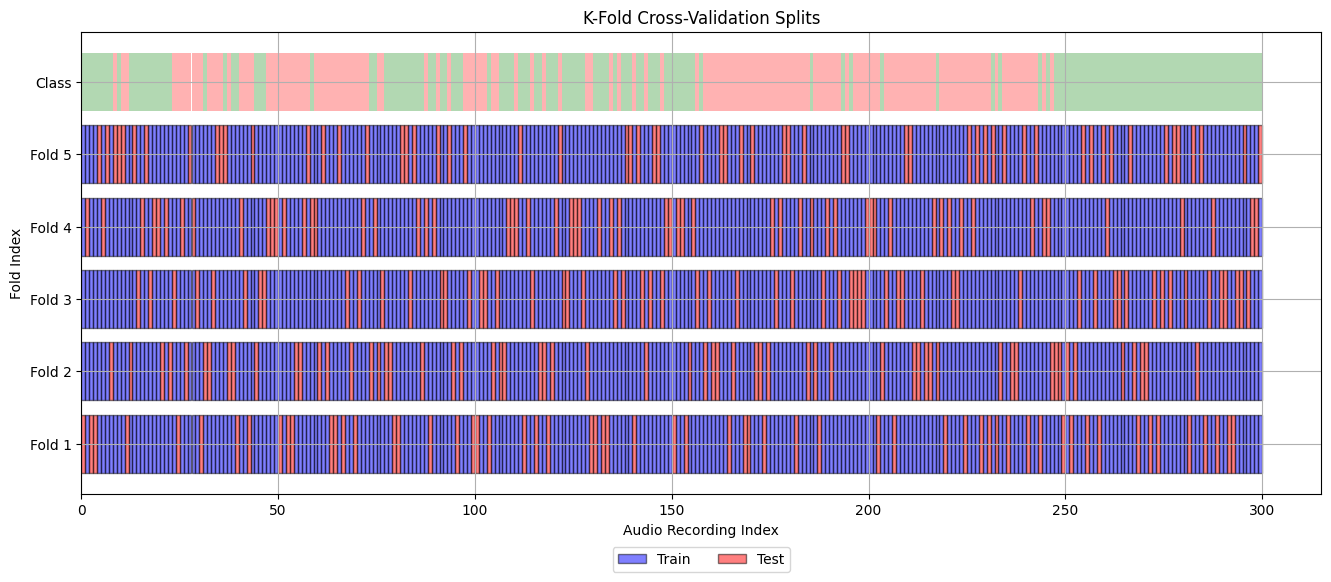

Fold:  1 
-Train:	Frame Size (Dataset): 63315 		Frame Size (CV Split): 63315 		Audio Files: 240
-Test:	Frame Size (Dataset): 19642 		Frame Size (CV Split): 19642 		Audio Files: 60 

Fold:  2 
-Train:	Frame Size (Dataset): 68044 		Frame Size (CV Split): 68044 		Audio Files: 240
-Test:	Frame Size (Dataset): 14913 		Frame Size (CV Split): 14913 		Audio Files: 60 

Fold:  3 
-Train:	Frame Size (Dataset): 69040 		Frame Size (CV Split): 69040 		Audio Files: 240
-Test:	Frame Size (Dataset): 13917 		Frame Size (CV Split): 13917 		Audio Files: 60 

Fold:  4 
-Train:	Frame Size (Dataset): 63593 		Frame Size (CV Split): 63593 		Audio Files: 240
-Test:	Frame Size (Dataset): 19364 		Frame Size (CV Split): 19364 		Audio Files: 60 

Fold:  5 
-Train:	Frame Size (Dataset): 67836 		Frame Size (CV Split): 67836 		Audio Files: 240
-Test:	Frame Size (Dataset): 15121 		Frame Size (CV Split): 15121 		Audio Files: 60 



In [7]:
mean_values = df_ZCR.drop(['amp', 'key'], axis=1).mean()

# Fill NaN values with the mean of each column, excluding 'amp' and 'key'
mean_values = df_ZCR.drop(['amp', 'key'], axis=1).mean()
df_ZCR.fillna(mean_values, inplace=True)

# Check for NaN values in the DataFrame
columns_with_nans = df_ZCR.isna().any()

if columns_with_nans.any():
    print("Columns with NaN values:")
    print(columns_with_nans[columns_with_nans])
else:
    print("There are no NaN values in any column of the DataFrame.")

norm_ignore_cols = ['key', 'amp', 'Frame_index', 'label', 'sf', 'start', 'end']
nan_handling = 'median'  # Or 'mean', 'mode', '0', or 'None'

cv_strat = CrossValSplit(df_single_frame=df_ZCR,
                        non_cough_keys=df_from_save[df_from_save['cough_start_end'].isna()].index,
                        normalize=True,
                        norm_ignore_cols=norm_ignore_cols,
                        nan_handling=nan_handling)
cv_strat_data = cv_strat.cross_val(stratified=True,
                                   shuffle=True,
                                   plot=True,
                                   show_fold_info=True,
                                   )

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, recall_score, f1_score, precision_score, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from fastcore.basics import GetAttr
from fastai.tabular.data import TabularPandas
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tabulate import tabulate
from tqdm.auto import tqdm
import seaborn as sns
import multiprocessing
from sklearn.utils.fixes import loguniform
from scipy import stats
import torch
import time
import joblib

os.makedirs('./RF_models', exist_ok=True)

def save_feature_importance_table(grid, filename, output_dir='./'):
    """Saves a feature importance grid as a PNG image.

    Args:
        grid (pandas.DataFrame): The feature importance grid.
        filename (str): The desired filename for the PNG image.
        output_dir (str, optional): Directory to save the image. Defaults to the current directory.
    """
    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, filename)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, len(grid) * 0.5))  # Adjust size as needed

    # Hide axes
    ax.axis('off')

    # Create the table plot
    table = ax.table(cellText=grid.values,
                     colLabels=grid.columns,
                     cellLoc='center',
                     loc='center')

    # Adjust table style
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Adjust scaling as needed

    # Save the figure
    plt.tight_layout()
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Feature importance table saved as PNG: {filepath}")

def save_table_as_png(table, filename, output_dir='./'):
    """Saves a table generated with tabulate as a PNG image."""
    os.makedirs(output_dir, exist_ok=True)
    filepath = os.path.join(output_dir, filename)

    try:
        # Split the table into rows
        rows = table.split('\n')

        # Remove any empty rows
        rows = [row for row in rows if row.strip()]

        # Determine the number of columns
        num_columns = max(len(row.split('|')) - 1 for row in rows)  # Subtract 1 for the leading '|'

        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(num_columns * 2, len(rows) * 0.5))

        # Hide axes
        ax.axis('off')

        # Create the table plot
        table_data = []
        for row in rows[1:]:  # Skip the header row
            # Split the row and remove any empty strings
            cells = [cell.strip() for cell in row.split('|') if cell.strip()]
            # Pad the row with empty strings if necessary
            cells += [''] * (num_columns - len(cells))
            if cells:
                table_data.append(cells)

        # Extract headers
        headers = [header.strip() for header in rows[0].split('|') if header.strip()]
        headers += [''] * (num_columns - len(headers))

        # Create the table plot
        table = ax.table(cellText=table_data,
                         colLabels=headers,
                         cellLoc='center',
                         loc='center')

        # Adjust table style
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.2, 1.2)

        # Save the figure
        plt.tight_layout()
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Table saved as PNG: {filepath}")
    except Exception as e:
        print(f"Error saving table as PNG: {str(e)}")
        print("Table structure:")
        print(table)

# Function to create hyperparameter table data
def create_hyperparameter_table(results):
    hyperparameter_table_data = []
    for i, result in enumerate(results, 1):
        row = [f"Fold {i}"] + [str(result['Best Params'].get(param, '')) for param in results[0]['Best Params'].keys()]
        hyperparameter_table_data.append(row)
    return hyperparameter_table_data

def generate_metrics_table(fold_metrics, avg_train_metrics, avg_test_metrics, metric_names):
    table_data = []
    train_header = metric_names[:len(metric_names)//2]
    test_header = [f"{name} (Test)" for name in metric_names[len(metric_names)//2:]]
    header = ["Fold"] + train_header + test_header

    for i, fold_metrics_row in enumerate(fold_metrics):
        train_row = fold_metrics_row[:len(metric_names)//2]
        test_row = fold_metrics_row[len(metric_names)//2:]
        row = [f"Fold {i+1}"] + train_row + test_row
        table_data.append(row)

    # Convert avg_train_metrics and avg_test_metrics dictionaries to lists
    avg_train_row = [avg_train_metrics[metric] for metric in train_header]
    avg_test_row = [avg_test_metrics[metric] for metric in metric_names[len(metric_names)//2:]]
    avg_row = ["Average"] + avg_train_row + avg_test_row
    table_data.append(avg_row)

    # Correct the column alignment here
    table = tabulate(table_data, headers=header, tablefmt="grid", colalign=("left",) * len(header))  # Align all columns to the left
    return table



# Custom data loader
def lightning_loader(X, y):
    dataset = TensorDataset(torch.from_numpy(X.values).float(), torch.from_numpy(y.values).long())
    loader = DataLoader(dataset)
    return loader


def get_data_loaders(df_ZCR, shuffle=False):
    feature_names = df_ZCR.drop(['label', 'key', 'amp'], axis=1).columns.tolist()
    df_ZCR_X = df_ZCR.drop(['label', 'key', 'amp'], axis=1).values
    df_ZCR_y = df_ZCR['label'].values

    # Check for NaN values in the DataFrame before splitting
    if np.isnan(df_ZCR_X).any():
        print("Columns with NaN values before splitting:")
        nan_counts = np.isnan(df_ZCR_X).sum(axis=0)
        nan_table = pd.DataFrame({'Column': df_ZCR.drop(['label', 'key', 'amp'], axis=1).columns[nan_counts > 0], 'NaN Count': nan_counts[nan_counts > 0]})
        print(tabulate(nan_table, headers='keys', tablefmt='grid'))
    else:
        print("There are no NaN values in any column of the DataFrame before splitting.")

    table_data = []  # List to store data for the table

    for fold, (train_idx, test_idx) in enumerate(cv_strat_data):
        X_train = df_ZCR_X[train_idx]
        y_train = df_ZCR_y[train_idx]
        X_test = df_ZCR_X[test_idx]
        y_test = df_ZCR_y[test_idx]

        # Check for mismatched column names between X_train and X_test
        mismatched_columns = False

        # Calculate class balance
        train_class_balance = np.bincount(y_train, minlength=2)
        test_class_balance = np.bincount(y_test, minlength=2)

        # Append the data to the table_data list
        table_data.append([
            f"Fold {fold+1:>7}",
            str(X_train.shape).ljust(16),
            f"0: {train_class_balance[0]:>5}, 1: {train_class_balance[1]:>5}",
            str(y_train.shape).ljust(16),
            f"0: {train_class_balance[0]:>5}, 1: {train_class_balance[1]:>5}",
            str(X_test.shape).ljust(16),
            f"0: {test_class_balance[0]:>5}, 1: {test_class_balance[1]:>5}",
            str(y_test.shape).ljust(16),
            f"0: {test_class_balance[0]:>5}, 1: {test_class_balance[1]:>5}",
            "Mismatched columns" if mismatched_columns else ""
        ])

    # Define headers for the table
    headers = [
        "Fold",
        "X_train Shape", "X_train Class Balance",
        "y_train Shape", "y_train Class Balance",
        "X_test Shape", "X_test Class Balance",
        "y_test Shape", "y_test Class Balance",
        "Column Mismatch"
    ]

    # Print the table
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    return df_ZCR_X, df_ZCR_y, feature_names

# Metrics
def get_metrics(y_true, y_pred, y_pred_proba):
    conf_mat = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_mat.ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) != 0 else 0

    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_pred_proba),
        'Recall': recall_score(y_true, y_pred),
        'Specificity': specificity,
        'F1': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'NPV': npv,
        'PPV': ppv,
        'MSE': mean_squared_error(y_true, y_pred),
        'Micro F1': f1_score(y_true, y_pred, average='micro'),
        'Macro F1': f1_score(y_true, y_pred, average='macro')
    }

   # Calculate 95% confidence intervals
    confidence = 0.95
    n = len(y_true)  # Sample size
    for metric_name in ['Accuracy', 'AUC', 'Recall', 'Specificity', 'F1', 'Precision', 'NPV', 'PPV']:
        z_score = stats.norm.ppf((1 + confidence) / 2)
        std_error = np.sqrt((metrics[metric_name] * (1 - metrics[metric_name])) / n)
        margin_of_error = z_score * std_error

        # Store CI as a tuple directly with the metric value
        metrics[metric_name] = (metrics[metric_name], (metrics[metric_name] - margin_of_error, metrics[metric_name] + margin_of_error))

    return metrics, conf_mat



metric_names = [
    'Accuracy', 'AUC', 'Recall', 'Specificity',
    'F1', 'Precision', 'NPV', 'PPV',
    'Accuracy', 'AUC',
    'Recall', 'Specificity',
    'F1', 'PPV', 'NPV'
]


# GridSearchCV parameters
param_grid = {
    'n_estimators': [10, 12, 13, 14, 15, 16, 17, 18, 19 ,20],#[100, 200, 300],
    'max_depth': [None],#[None] + list(range(10, 34)),
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'bootstrap': [True],
    'max_features': ['sqrt'], #Auto 'sqrt'
    'class_weight': ['balanced_subsample'],# 'balanced', None,'balanced_subsample'
}

# Define the scoring metrics - OPTIONAL
# scoring = {
#     # 'accuracy': make_scorer(accuracy_score),
#     # 'precision': make_scorer(precision_score, average='weighted'),
#     # 'recall': make_scorer(recall_score, average='weighted'),
#     # 'f1': make_scorer(f1_score, average='weighted'),
#     # 'roc_auc': make_scorer(roc_auc_score, average='weighted', needs_proba=True),
#     'average_precision': make_scorer(average_precision_score, average='weighted', needs_proba=True)
# }



# Create a list of dictionaries where each dictionary represents a row
param_grid_table = []
max_values = max(len(values) for values in param_grid.values())

# Transpose the table for vertical display
transposed_table = []
headers = list(param_grid.keys())
for i in range(max_values):
    row = {}
    for key, values in param_grid.items():
        if i < len(values):
            row[key] = values[i]
        else:
            row[key] = None  # or you can use an empty string ''
    param_grid_table.append(row)
for i, header in enumerate(headers):
    row = [header]
    for param_dict in param_grid_table:
        row.append(param_dict[header])
    transposed_table.append(row)



# Print hyperparameters
print("Hyperparameters:")
print(tabulate(transposed_table, headers=['Parameter'] + [f'Value {i+1}' for i in range(max_values)], tablefmt="grid"))
print()

if torch.cuda.is_available():
    print("CUDA is available.")
    print("GPU(s):", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print("Device {}: {}".format(i, torch.cuda.get_device_name(i)))
else:
    print("CUDA is not available.")
# Get the number of CPU cores
num_cpus = multiprocessing.cpu_count()

print(f"Number of CPU cores available: {num_cpus}")

# Get the number of CPU cores
num_cpus = multiprocessing.cpu_count()

# Define n_jobs for GridSearchCV
n_jobs_grid_search = -1  # or any other value you want to use
print(f'Using {num_cpus} CPUs')

# Set pre_dispatch based on the number of CPU cores
pre_dispatch_value = f'{2 * num_cpus}*n_jobs'

# Train and evaluate models
X, y, feature_names = get_data_loaders(df_ZCR, shuffle=False)
num_folds = len(cv_strat_data)

# Store results in a list of dictionaries
results = []
fold_metrics = []

# Perform hyperparameter tuning with tqdm for progress bar
for i, (train_idx, test_idx) in enumerate(tqdm(cv_strat_data,
                                               desc="Hyperparameter Tuning",
                                               unit="fold")):
    start_time = time.time()
    print(f"Fold {i + 1}/{num_folds}")

    X_train, X_valid = X[train_idx], X[test_idx]
    y_train, y_valid = y[train_idx], y[test_idx]

    searcher = GridSearchCV(RandomForestClassifier(
                            criterion='entropy',
                            oob_score=True,
                            random_state=42,
                            n_jobs = -1),
                            param_grid,
                            verbose=10,
                            cv=5,
                            refit='precision',
                            n_jobs=-1,
                            # scoring=scoring,
                            # pre_dispatch = pre_dispatch_value,
                            # return_train_score = True
                            )
    searcher.fit(X_train, y_train)
    best_params = searcher.best_params_

    # Print best hyperparameters in a tabular format
    best_params_table = [[key, value] for key, value in best_params.items()]
    print("Best Hyperparameters:")
    print(tabulate(best_params_table, headers=['Parameter', 'Value'], tablefmt="grid"))

    model = RandomForestClassifier(**best_params)
    model.fit(X_train, y_train)

    model_filename = f'./RF_models/RandomForest_ZCR_Cough-Detection_Fold-{i+1}.pkl'
    joblib.dump(model, model_filename)
    print(f"Model saved: {model_filename}")

    train_preds = model.predict(X_train)
    train_preds_proba = model.predict_proba(X_train)[:, 1]
    valid_preds = model.predict(X_valid)
    valid_preds_proba = model.predict_proba(X_valid)[:, 1]

    train_metrics, train_conf_mat = get_metrics(y_train, train_preds, train_preds_proba)
    valid_metrics, valid_conf_mat = get_metrics(y_valid, valid_preds, valid_preds_proba)

    # Append metrics to fold_metrics
    fold_metrics.append(list(train_metrics.values()) + list(valid_metrics.values()))

    # --- Print Fold Results ---
    print(f"--- Fold {i+1} Results ---\n")

    # --- Metrics Grid ---
    metric_table_data = [
        ["Metric", "Train", "Valid"],
        ["Accuracy", f"{train_metrics['Accuracy'][0]:.4f}", f"{valid_metrics['Accuracy'][0]:.4f}"],
        ["AUC", f"{train_metrics['AUC'][0]:.4f}", f"{valid_metrics['AUC'][0]:.4f}"],
        ["Recall", f"{train_metrics['Recall'][0]:.4f}", f"{valid_metrics['Recall'][0]:.4f}"],
        ["Specificity", f"{train_metrics['Specificity'][0]:.4f}", f"{valid_metrics['Specificity'][0]:.4f}"],
        ["F1", f"{train_metrics['F1'][0]:.4f}", f"{valid_metrics['F1'][0]:.4f}"],
        ["Precision", f"{train_metrics['Precision'][0]:.4f}", f"{valid_metrics['Precision'][0]:.4f}"],
        ["NPV", f"{train_metrics['NPV'][0]:.4f}", f"{valid_metrics['NPV'][0]:.4f}"],
        ["PPV", f"{train_metrics['PPV'][0]:.4f}", f"{valid_metrics['PPV'][0]:.4f}"]
        ]
    print(tabulate(metric_table_data, headers="firstrow", tablefmt="grid"))

    # --- Confusion Matrix Grid ---
    print("\nConfusion Matrices:\n")

    print("Train Confusion Matrix:")
    train_conf_mat_data = [
        ["", "Predicted: 1 (Positive)", "Predicted: 0 (Negative)"],
        ["",'TP','FN'],
        ["Actual: 1 (Positive)", train_conf_mat[1][1], train_conf_mat[1][0]],  # TP, FN
        ["Actual: 0 (Negative)", train_conf_mat[0][1], train_conf_mat[0][0]],   # FP, TN
        ["",'FP','TN'],
    ]
    print(tabulate(train_conf_mat_data, headers="firstrow", tablefmt='grid', numalign='right'))
    print("\n") # Add extra line for separation

    print("Valid Confusion Matrix:")
    valid_conf_mat_data = [
        ["", "Predicted: 1 (Positive)", "Predicted: 0 (Negative)"],
        ["",'TP','FN'],
        ["cough: 1 (Positive)(TP)", valid_conf_mat[1][1], valid_conf_mat[1][0]],  # TP, FN
        ["non-cough: 0 (Negative)(FP)", valid_conf_mat[0][1], valid_conf_mat[0][0]],   # FP, TN
        ["",'FP','TN'],

    ]
    print(tabulate(valid_conf_mat_data, headers="firstrow", tablefmt='grid', numalign='right'))
    print("\n")

    results.append({
        'Fold': i + 1,
        'Train': train_metrics,
        'Valid': valid_metrics,
        'Train Confusion Matrix': train_conf_mat,
        'Valid Confusion Matrix': valid_conf_mat,
        'Best Params': best_params
    })

    end_time = time.time()
    elapsed_time = end_time - start_time
    remaining_time = (num_folds - (i + 1)) * elapsed_time
    tqdm.write(f"Fold {i+1}/{num_folds} completed in {elapsed_time:.2f}s - Estimated time remaining: {remaining_time:.2f}s")

# --- Generate Summary Table ---
all_train_metrics = [fold['Train'] for fold in results]
all_valid_metrics = [fold['Valid'] for fold in results]

avg_train_metrics = pd.DataFrame(all_train_metrics).applymap(lambda x: x[0] if isinstance(x, tuple) else x).mean().round(4).to_dict()
avg_valid_metrics = pd.DataFrame(all_valid_metrics).applymap(lambda x: x[0] if isinstance(x, tuple) else x).mean().round(4).to_dict()

table_data = []
for i, fold_data in enumerate(results):
    row_data = [f"Fold {i+1}"]
    for metric_name in fold_data['Train'].keys():
        train_value = fold_data['Train'][metric_name]
        valid_value = fold_data['Valid'][metric_name]

        # Format train_str and valid_str, extracting values from tuples
        train_str = f"{train_value[0]:.4f} ({train_value[1][0]:.4f} - {train_value[1][1]:.4f})" if isinstance(train_value, tuple) else f"{train_value:.4f}"
        valid_str = f"{valid_value[0]:.4f} ({valid_value[1][0]:.4f} - {valid_value[1][1]:.4f})" if isinstance(valid_value, tuple) else f"{valid_value:.4f}"

        # Add Train and Test metrics to the row
        row_data.append(train_str)
        row_data.append(valid_str)
    table_data.append(row_data)

# Add average row to the table data
avg_row_data = ['Average']
for metric_name in avg_train_metrics.keys():

    # Calculate average values outside the loop
    train_value = avg_train_metrics[metric_name]
    valid_value = avg_valid_metrics[metric_name]

    if isinstance(train_value, tuple):
        train_str = f"{train_value[0]:.4f} - {train_value[1]:.4f}"
    else:
        train_str = f"{train_value:.4f}"

    if isinstance(valid_value, tuple):
        valid_str = f"{valid_value[0]:.4f} - {valid_value[1]:.4f}"
    else:
        valid_str = f"{valid_value:.4f}"

    avg_row_data.append(f"{train_str} ({valid_str})")

table_data.append(avg_row_data)

# Create the header for the table
if results:
    header = ["Fold"] + [f"{k} (Train)" for k in results[0]['Train'].keys()] + [f"{k} (Test)" for k in results[0]['Valid'].keys()]

    # Display the table using tabulate
    print(tabulate(table_data, headers=header, tablefmt="grid"))
else:
    print("No results to display. Check if the loop iterated successfully.")

# Compute permutation importance
model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train)

# Assuming model, X_train, y_train, and feature_names are already defined
perm_importance = permutation_importance(model, X_train, y_train)

# Combine feature names with their importances
feature_importances = list(zip(feature_names, perm_importance.importances_mean))

# Sort features by importance in descending order
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Create a DataFrame for easier manipulation
df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Round the importances to 12 decimal places
df['Importance'] = df['Importance'].round(12)

# Function to create a grid of features
def create_feature_grid(df, n_rows=10):
    grids = []
    for i in range(0, len(df), n_rows):
        grid = df.iloc[i:i+n_rows]
        grids.append(grid)
    return grids

# Create the grids
grids = create_feature_grid(df)

# Print the grids in a pretty format
for i, grid in enumerate(grids):
    print(f"Grid {i+1} structure:")
    print(grid.info())
    print(grid.head())

    grid_table = tabulate(grid, headers='keys', tablefmt='pretty', showindex=False)
    save_table_as_png(grid_table, f'feature_importance_grid_{i+1}.png', output_dir='./RF_feature_importance')

# --- Plot and Save Metrics ---

def plot_fold_metrics(results, metric_names, output_dir='./'):
    """Plots individual and combined line graphs for metrics across folds, saving them as PNG files.

    Args:
        results (list): List of dictionaries containing fold results.
        metric_names (list): List of metric names to plot.
        output_dir (str, optional): Directory to save the plots. Defaults to the current directory.
    """
    num_folds = len(results)

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Individual Metric Plots
    for i, metric_name in enumerate(metric_names):
        plt.figure(figsize=(10, 6))
        train_scores = [fold['Train'][metric_name][0] for fold in results]
        valid_scores = [fold['Valid'][metric_name][0] for fold in results]

        plt.plot(range(1, num_folds + 1), train_scores, label='Train')
        plt.plot(range(1, num_folds + 1), valid_scores, label='Validation')

        plt.xlabel('Fold')
        plt.ylabel(metric_name)
        plt.title(f'{metric_name} across Folds')
        plt.legend()
        plt.grid(True)

        plt.savefig(os.path.join(output_dir, f'RF_TrainTest_{metric_name}_5-folds.png'))
        plt.close()

    # Combined Metrics Plot
    plt.figure(figsize=(15, 10))
    for metric_name in metric_names:
        train_scores = [fold['Train'][metric_name][0] for fold in results]
        valid_scores = [fold['Valid'][metric_name][0] for fold in results]

        plt.plot(range(1, num_folds + 1), train_scores, label=f'{metric_name} (Train)')
        plt.plot(range(1, num_folds + 1), valid_scores, label=f'{metric_name} (Validation)')

    plt.xlabel('Fold')
    plt.ylabel('Metric Score')
    plt.title('All Metrics across Folds')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Legend outside plot
    plt.grid(True)
    plt.tight_layout()  # Adjust layout for legend outside
    plt.savefig(os.path.join(output_dir, 'RF_TrainTest_All_Metrics_5-folds.png'))
    plt.close()



# --- Generate and Save Hyperparameter Table ---

def round_value(x, decimals=3):
    """Round a value or the first element of a tuple to the specified number of decimal places."""
    if isinstance(x, tuple):
        return round(x[0], decimals)
    elif isinstance(x, (int, float)):
        return round(x, decimals)
    else:
        return x  # Return as is if it's neither a tuple nor a number

def generate_metrics_table(fold_metrics, avg_train_metrics, avg_valid_metrics, metric_names):
    table_data = []
    for i, fold_metrics_row in enumerate(fold_metrics):
        train_row = [round_value(x, 3) for x in fold_metrics_row[:len(metric_names)//2]]
        test_row = [round_value(x, 3) for x in fold_metrics_row[len(metric_names)//2:]]
        row = [f"Fold {i+1}"] + train_row + test_row
        table_data.append(row)

    # Round average metrics
    avg_train_row = [round_value(avg_train_metrics[metric], 3) for metric in metric_names[:len(metric_names)//2]]
    avg_test_row = [round_value(avg_valid_metrics[metric], 3) for metric in metric_names[len(metric_names)//2:]]
    avg_row = ["Average"] + avg_train_row + avg_test_row
    table_data.append(avg_row)

    header = ["Fold"] + [f"{k} (Train)" for k in metric_names[:len(metric_names)//2]] + [f"{k} (Test)" for k in metric_names[len(metric_names)//2:]]
    return tabulate(table_data, headers=header, tablefmt="grid")

def plot_all_metrics(results, metric_names, output_dir='./'):
    num_folds = len(results)
    plt.figure(figsize=(15, 10))

    # Define a list of colors and linestyles
    colors = plt.cm.tab10.colors
    linestyles = ['-', '--', '-.', ':']

    # Create a set of unique metric names
    unique_metrics = set(metric_names)

    for idx, metric_name in enumerate(unique_metrics):
        try:
            train_scores = []
            valid_scores = []
            for fold in results:
                train_value = fold['Train'].get(metric_name)
                valid_value = fold['Valid'].get(metric_name)

                if train_value is not None:
                    train_scores.append(float(round_value(train_value, 3)))
                if valid_value is not None:
                    valid_scores.append(float(round_value(valid_value, 3)))

            if train_scores and valid_scores:
                color = colors[idx % len(colors)]
                linestyle = linestyles[idx % len(linestyles)]
                plt.plot(range(1, len(train_scores) + 1), train_scores, label=f'{metric_name} (Train)', marker='o', color=color)
                plt.plot(range(1, len(valid_scores) + 1), valid_scores, label=f'{metric_name} (Validation)', marker='s', linestyle=linestyle, color=color)
            else:
                print(f"Warning: No valid data for metric {metric_name}")
        except Exception as e:
            print(f"Error plotting metric {metric_name}: {str(e)}")

    plt.xlabel('Fold')
    plt.ylabel('Metric Score')
    plt.title('All Metrics across Folds')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Legend outside plot
    plt.grid(True)
    plt.tight_layout()  # Adjust layout for legend outside
    plt.savefig(f'{output_dir}/All_Metrics_across_Folds.png', dpi=300, bbox_inches='tight')
    plt.close()


# In the main code:
# Generate and print the metrics table
main_results_table = generate_metrics_table(fold_metrics, avg_train_metrics, avg_valid_metrics, metric_names)
print(main_results_table)

# Save the table as PNG
save_table_as_png(main_results_table, 'main_results_table.png', output_dir='./RF_tables')

# Plot all metrics on one graph
plot_all_metrics(results, metric_names, output_dir='./RF_plots')

# --- Plot and Save Metrics ---
plot_fold_metrics(results, metric_names, output_dir='./RF_plots')

Hyperparameters:
+-------------------+--------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+
| Parameter         | Value 1            |   Value 2 |   Value 3 |   Value 4 |   Value 5 |   Value 6 |   Value 7 |   Value 8 |   Value 9 |   Value 10 |
+===================+====================+===========+===========+===========+===========+===========+===========+===========+===========+============+
| n_estimators      | 10                 |        12 |        13 |        14 |        15 |        16 |        17 |        18 |        19 |         20 |
+-------------------+--------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+
| max_depth         |                    |           |           |           |           |           |           |           |           |            |
+-------------------+--------------------+-----------+-----------+-----

Hyperparameter Tuning:   0%|          | 0/5 [00:00<?, ?fold/s]

Fold 1/5
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best Hyperparameters:
+-------------------+--------------------+
| Parameter         | Value              |
+===================+====================+
| bootstrap         | True               |
+-------------------+--------------------+
| class_weight      | balanced_subsample |
+-------------------+--------------------+
| max_depth         |                    |
+-------------------+--------------------+
| max_features      | sqrt               |
+-------------------+--------------------+
| min_samples_leaf  | 2                  |
+-------------------+--------------------+
| min_samples_split | 2                  |
+-------------------+--------------------+
| n_estimators      | 20                 |
+-------------------+--------------------+
Model saved: ./RF_models/RandomForest_ZCR_Cough-Detection_Fold-1.pkl
--- Fold 1 Results ---

+-------------+---------+---------+
| Metric      |   Train |   Valid |
+=============+=========+=========+
| Accuracy    |  0.9943 |  0.9422 |
+---------

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best Hyperparameters:
+-------------------+--------------------+
| Parameter         | Value              |
+===================+====================+
| bootstrap         | True               |
+-------------------+--------------------+
| class_weight      | balanced_subsample |
+-------------------+--------------------+
| max_depth         |                    |
+-------------------+--------------------+
| max_features      | sqrt               |
+-------------------+--------------------+
| min_samples_leaf  | 2                  |
+-------------------+--------------------+
| min_samples_split | 2                  |
+-------------------+--------------------+
| n_estimators      | 20                 |
+-------------------+--------------------+
Model saved: ./RF_models/RandomForest_ZCR_Cough-Detection_Fold-2.pkl
--- Fold 2 Results ---

+-------------+---------+---------+
| Metric      |   Train |   Valid |
+=============+=========+=========+
| Accuracy    |  0.9943 |  0.9154 |
+---------

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best Hyperparameters:
+-------------------+--------------------+
| Parameter         | Value              |
+===================+====================+
| bootstrap         | True               |
+-------------------+--------------------+
| class_weight      | balanced_subsample |
+-------------------+--------------------+
| max_depth         |                    |
+-------------------+--------------------+
| max_features      | sqrt               |
+-------------------+--------------------+
| min_samples_leaf  | 2                  |
+-------------------+--------------------+
| min_samples_split | 2                  |
+-------------------+--------------------+
| n_estimators      | 20                 |
+-------------------+--------------------+
Model saved: ./RF_models/RandomForest_ZCR_Cough-Detection_Fold-3.pkl
--- Fold 3 Results ---

+-------------+---------+---------+
| Metric      |   Train |   Valid |
+=============+=========+=========+
| Accuracy    |  0.9945 |  0.9355 |
+---------

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best Hyperparameters:
+-------------------+--------------------+
| Parameter         | Value              |
+===================+====================+
| bootstrap         | True               |
+-------------------+--------------------+
| class_weight      | balanced_subsample |
+-------------------+--------------------+
| max_depth         |                    |
+-------------------+--------------------+
| max_features      | sqrt               |
+-------------------+--------------------+
| min_samples_leaf  | 2                  |
+-------------------+--------------------+
| min_samples_split | 2                  |
+-------------------+--------------------+
| n_estimators      | 20                 |
+-------------------+--------------------+
Model saved: ./RF_models/RandomForest_ZCR_Cough-Detection_Fold-4.pkl
--- Fold 4 Results ---

+-------------+---------+---------+
| Metric      |   Train |   Valid |
+=============+=========+=========+
| Accuracy    |  0.9944 |  0.9488 |
+---------

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Best Hyperparameters:
+-------------------+--------------------+
| Parameter         | Value              |
+===================+====================+
| bootstrap         | True               |
+-------------------+--------------------+
| class_weight      | balanced_subsample |
+-------------------+--------------------+
| max_depth         |                    |
+-------------------+--------------------+
| max_features      | sqrt               |
+-------------------+--------------------+
| min_samples_leaf  | 2                  |
+-------------------+--------------------+
| min_samples_split | 2                  |
+-------------------+--------------------+
| n_estimators      | 20                 |
+-------------------+--------------------+
Model saved: ./RF_models/RandomForest_ZCR_Cough-Detection_Fold-5.pkl
--- Fold 5 Results ---

+-------------+---------+---------+
| Metric      |   Train |   Valid |
+=============+=========+=========+
| Accuracy    |  0.9943 |  0.9355 |
+---------

# Below is for making graphs and animations - outdated

In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to get a random audio file key from a DataFrame
def get_random_audio_file(df):
    """
    Selects a random audio file key from a DataFrame.

    Args:
    df (pd.DataFrame): A DataFrame containing audio file keys.

    Returns:
    str: The key of a random audio file.
    """
    # Assuming 'key' is in one of the DataFrames in all_frames_from_save
    for frame_size in df:
        if 'key' in df[frame_size].columns:
            return random.choice(df[frame_size]['key'].tolist())
    raise ValueError("No 'key' column found in any of the DataFrames")

def plot_zcr_feature_distribution(all_frames, feature, frame_sizes=None, normalized=True):
    """
    Plots the distribution of a specific ZCR-related feature across different frame sizes.

    Args:
    all_frames (dict): Dictionary of DataFrames.
    feature (str): Base feature name (e.g., 'zcr', 'zc_speed').
    frame_sizes (list): Optional list of frame sizes to plot.
    normalized (bool): If True, normalizes the feature values for better comparison.
    """
    plt.figure(figsize=(12, 6))
    if frame_sizes is None:
        frame_sizes = sorted(all_frames.keys())

    for frame_size in frame_sizes:
        df = all_frames[frame_size]
        col = [c for c in df.columns if feature in c and str(frame_size) in c][0]

        if normalized:
            df[col] = (df[col] - df[col].mean()) / df[col].std()

        sns.kdeplot(data=df, x=col, label=f'Size {frame_size}')

    plt.title(f'Distribution of {feature.upper()} Across Frame Sizes' + (' (Normalized)' if normalized else ''))
    plt.xlabel(feature.upper())
    plt.ylabel('Density')
    plt.legend(title='Frame Size')
    plt.tight_layout()
    plt.show()

def plot_zcr_feature_by_label(all_frames, feature, frame_sizes=None):
    """
    Plots a specific ZCR-related feature against the label for different frame sizes.
    """
    if frame_sizes is None:
        frame_sizes = sorted(all_frames.keys())

    plt.figure(figsize=(15, 6))
    for i, frame_size in enumerate(frame_sizes, 1):
        plt.subplot(1, len(frame_sizes), i)
        df = all_frames[frame_size]
        col = [c for c in df.columns if feature in c and str(frame_size) in c][0]

        sns.boxplot(x='label', y=col, data=df)
        plt.title(f'{feature.upper()} vs Label (Size {frame_size})')
        plt.xlabel('Label')
        plt.ylabel(feature.upper())

    plt.tight_layout()
    plt.show()

def plot_zcr_feature_correlations(all_frames, frame_size=2048):
    """
    Plots a correlation matrix of all ZCR-related features for a given frame size.
    """
    df = all_frames[frame_size].copy()

    zcr_features = ['zcr', 'zc_count', 'zc_speed', 'zc_regularity', 'zc_perc_25', 'zc_perc_50', 'zc_perc_75']
    feature_cols = [col for col in df.columns if any(feature in col and str(frame_size) in col for feature in zcr_features)]

    # Calculate correlations
    corr_matrix = df[feature_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
    plt.title(f'Correlation Matrix of ZCR Features (Frame Size {frame_size})')
    plt.tight_layout()
    plt.show()

def visualize_zcr_features(all_frames, audio_file_key, frame_size=2048):
    """
    Visualizes all ZCR-related features for a specific audio file.
    """
    df = all_frames[frame_size].copy()
    df_filtered = df[df['key'] == audio_file_key].copy()

    if df_filtered.empty:
        raise ValueError(f"No data found for audio file key {audio_file_key} in frame size {frame_size}")

    df_filtered.sort_values('start', inplace=True)
    df_filtered.reset_index(drop=True, inplace=True)
    df_filtered['frame_index'] = range(len(df_filtered))

    zcr_features = ['zcr', 'zc_count', 'zc_speed', 'zc_regularity', 'zc_perc_25', 'zc_perc_50', 'zc_perc_75']
    feature_cols = [col for col in df_filtered.columns if any(feature in col and str(frame_size) in col for feature in zcr_features)]

    num_features = len(feature_cols)
    fig, axes = plt.subplots(num_features, 1, figsize=(12, 3 * num_features))
    fig.suptitle(f'ZCR Features for Audio File {audio_file_key} (Frame Size {frame_size})', fontsize=16)

    for ax, col in zip(axes.flatten(), feature_cols):
        ax.plot(df_filtered['frame_index'], df_filtered[col], marker='.', linestyle='-', linewidth=1, markersize=5)
        ax.set_ylabel(col)
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel('Frame Index')
    plt.tight_layout()
    plt.show()

    print(f"\nSample rows for audio file {audio_file_key}, frame size {frame_size}:")
    display_cols = ['key', 'start', 'end', 'label'] + feature_cols
    print(df_filtered[display_cols].head())

# Usage:
if all_frames_from_save:
    # Plot distributions for each ZCR-related feature
    for feature in ['zcr', 'zc_count', 'zc_speed', 'zc_regularity', 'zc_perc_25', 'zc_perc_50', 'zc_perc_75']:
        plot_zcr_feature_distribution(all_frames_from_save, feature)
        # You can also plot normalized distributions for better comparison
        plot_zcr_feature_distribution(all_frames_from_save, feature, normalized=True)

    # Plot each feature against the label
    for feature in ['zcr', 'zc_count', 'zc_speed', 'zc_regularity', 'zc_perc_25', 'zc_perc_50', 'zc_perc_75']:
        plot_zcr_feature_by_label(all_frames_from_save, feature)

    # Plot correlation matrix for a specific frame size
    plot_zcr_feature_correlations(all_frames_from_save, frame_size=2048)

    # Visualize all ZCR features for a random audio file
    random_audio_file_key = get_random_audio_file(all_frames_from_save)
    try:
        visualize_zcr_features(all_frames_from_save, random_audio_file_key)
    except ValueError as e:
        print(e)
        print("Trying another random file...")
        random_audio_file_key = get_random_audio_file(all_frames_from_save)
        visualize_zcr_features(all_frames_from_save, random_audio_file_key)

else:
    print("The 'all_frames_from_save' dictionary is empty.")

IndexError: list index out of range

<Figure size 1200x600 with 0 Axes>

Get Animations of ZCR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import librosa
from PIL import Image
from matplotlib.animation import FuncAnimation, PillowWriter

def find_busy_region(frame, window_size=100):
    """
    Finds a region in the frame with the most zero-crossings.

    Args:
    frame (np.array or list): The audio frame data.
    window_size (int): Size of the sliding window to check.

    Returns:
    tuple: (start_index, end_index) of the busiest region.
    """
    if isinstance(frame, list):
        frame = np.array(frame)

    zero_crossings = librosa.zero_crossings(frame, pad=False)
    counts = [np.sum(zero_crossings[i:i+window_size]) for i in range(len(frame) - window_size)]
    busiest_start = np.argmax(counts)
    return busiest_start, busiest_start + window_size

def animate_zero_crossings(frame, frame_size, output_file="zcr_animation.gif", fps=5, start_idx=None, end_idx=None, zoom_title=""):
    """
    Creates an animation showing how zero-crossings are identified one by one in an audio frame.
    Now supports zooming into a specific region.

    Args:
    frame (np.array or list): The audio frame data.
    frame_size (int): Size of the frame (for display purposes).
    output_file (str): Path to save the animation file.
    fps (int): Frames per second for the animation.
    start_idx, end_idx (int, optional): Start and end indices for zooming.
    zoom_title (str, optional): Additional title for zoomed view.
    """
    if isinstance(frame, list):
        frame = np.array(frame)

    zero_crossings = librosa.zero_crossings(frame, pad=False)
    zero_indices = np.where(zero_crossings)[0]

    fig, ax = plt.subplots(figsize=(12, 4))
    if start_idx is not None and end_idx is not None:
        ax.set_xlim(start_idx, end_idx)
        ax.set_ylim(-max(np.abs(frame[start_idx:end_idx]).max(), 0.001) * 1.1,
                   max(np.abs(frame[start_idx:end_idx]).max(), 0.001) * 1.1)
    else:
        ax.set_xlim(0, frame_size)
        ax.set_ylim(-max(np.abs(frame).max(), 0.001) * 1.1,
                   max(np.abs(frame).max(), 0.001) * 1.1)

    ax.axhline(y=0, color='red', linestyle='--', alpha=0.8, label='0th Boundary')
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Amplitude")
    ax.grid(alpha=0.3)

    line, = ax.plot(range(len(frame)), frame, color='blue', alpha=0.6, label='Waveform')
    scatter = ax.scatter([], [], color='green', marker='o', s=50, alpha=1, label='Zero Crossings')

    # Initialize the counting meter and current crossing index text
    count_text = ax.text(0.05, 0.95, 'Zero Crossings: 0', transform=ax.transAxes, ha='left', va='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=10)
    current_text = ax.text(0.95, 0.95, 'Current: -', transform=ax.transAxes, ha='right', va='top',
                         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7), fontsize=10)

    # Calculate ZCR for display
    zcr = np.sum(zero_crossings) / len(frame)
    title = f'Zero-Crossing Evolution (Frame Size {frame_size}, ZCR: {zcr:.3f})'
    if zoom_title:
        title += f'\n{zoom_title}'
    ax.set_title(title)

    lines = []  # To store line objects for each zero-crossing

    def update(frame_idx):
        relevant_indices = [idx for idx in zero_indices if start_idx <= idx <= end_idx] if start_idx is not None else zero_indices

        if frame_idx < len(relevant_indices):
            idx = relevant_indices[frame_idx]
            scatter.set_offsets(np.column_stack([relevant_indices[:frame_idx+1], frame[relevant_indices[:frame_idx+1]]]))

            if frame_idx > 0:
                prev_idx = relevant_indices[frame_idx - 1]
                line, = ax.plot([prev_idx, idx], [frame[prev_idx], frame[idx]], color='green', linewidth=2, alpha=0.8)
                lines.append(line)

            count_text.set_text(f'Zero Crossings: {frame_idx + 1}/{len(relevant_indices)}')
            current_text.set_text(f'Current: {idx}')
        else:
            count_text.set_text(f'Total Zero Crossings: {len(relevant_indices)}')
            current_text.set_text('Completed')

        return [scatter, count_text, current_text] + lines

    # The +10 ensures the animation pauses for a moment at the end
    ani = FuncAnimation(fig, update, frames=range(len(zero_indices) + 10), interval=1000/fps, blit=True)
    plt.legend(loc='lower right')

    # Save the animation
    writer = PillowWriter(fps=fps)
    ani.save(output_file, writer=writer)
    plt.close()
    print(f"Animation saved to {output_file}")

# Usage in your main code
if all_frames_from_save:
    random_audio_file_key = get_random_audio_file(all_frames_from_save)
    viz_frame_size = 512

    if viz_frame_size in all_frames_from_save:
        df = all_frames_from_save[viz_frame_size]
        df_file = df[df['key'] == random_audio_file_key].copy().sort_values('start').reset_index(drop=True)

        if not df_file.empty:
            amp_columns = [col for col in df_file.columns if 'amp' in col.lower() and df_file[col].apply(lambda x: isinstance(x, (list, np.ndarray))).all()]
            if amp_columns:
                amp_column = amp_columns[0]
                print(f"Using '{amp_column}' for frame amplitude data.")

                # Get a random frame
                random_frame_index = np.random.randint(0, len(df_file))
                random_frame = df_file.iloc[random_frame_index][amp_column]

                # Full view animation
                animate_zero_crossings(random_frame, viz_frame_size,
                                     output_file=f"zcr_animation_full_{random_audio_file_key}_{random_frame_index}.gif",
                                     fps=5)

                # Find a busy region for zooming
                start_idx, end_idx = find_busy_region(random_frame, window_size=100)

                # Zoomed-in view animation
                animate_zero_crossings(random_frame, viz_frame_size,
                                     output_file=f"zcr_animation_zoomed_{random_audio_file_key}_{random_frame_index}_{start_idx}_{end_idx}.gif",
                                     fps=2,  # Slower for the zoomed view
                                     start_idx=start_idx, end_idx=end_idx,
                                     zoom_title=f"Zoomed Region: {start_idx}-{end_idx}")
            else:
                print("No suitable column found containing frame amplitude data.")
        else:
            print(f"No data found for audio file key {random_audio_file_key} in frame size {viz_frame_size}")
    else:
        print(f"Frame size {viz_frame_size} not found. Available sizes: {list(all_frames_from_save.keys())}")
else:
    print("The 'all_frames_from_save' dictionary is empty.")

Using 'amp' for frame amplitude data.
Animation saved to zcr_animation_full_d769f90f-8183-4c42-8ea6-cf992ee40a64_524.gif
Animation saved to zcr_animation_zoomed_d769f90f-8183-4c42-8ea6-cf992ee40a64_524_7_107.gif


## 2nd attempt

Calculated ZCR for frame size 256
Calculated ZCR for frame size 512
Calculated ZCR for frame size 1024
Calculated ZCR for frame size 2048

First few rows of the DataFrame with ZCR (frame size 1024):
                                    key  frame_index       zcr  label
0  008c1c9e-aeef-40c5-846c-24f1b964f884            0  0.000000      0
1  008c1c9e-aeef-40c5-846c-24f1b964f884            1  0.222656      0
2  008c1c9e-aeef-40c5-846c-24f1b964f884            2  0.269531      0
3  008c1c9e-aeef-40c5-846c-24f1b964f884            3  0.076172      0
4  008c1c9e-aeef-40c5-846c-24f1b964f884            4  0.080078      0


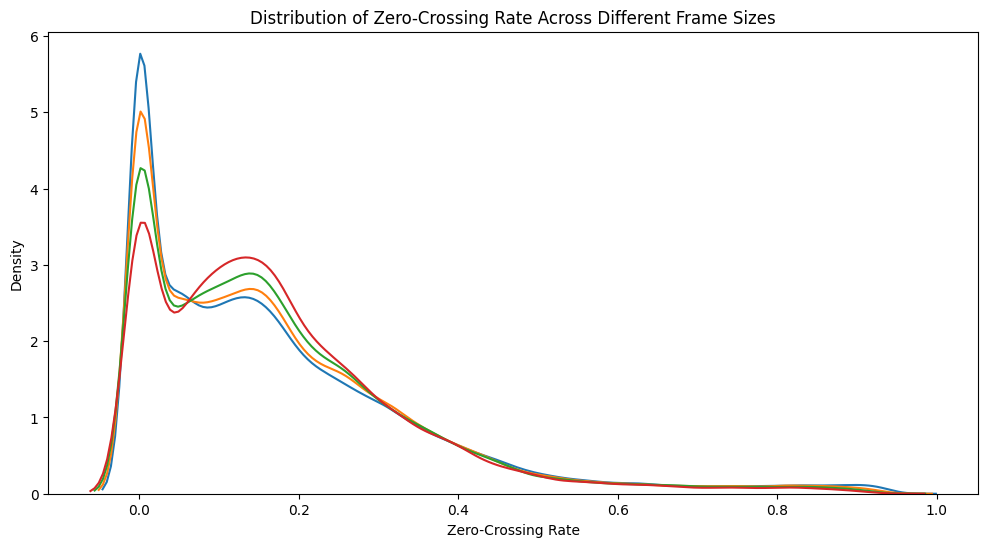

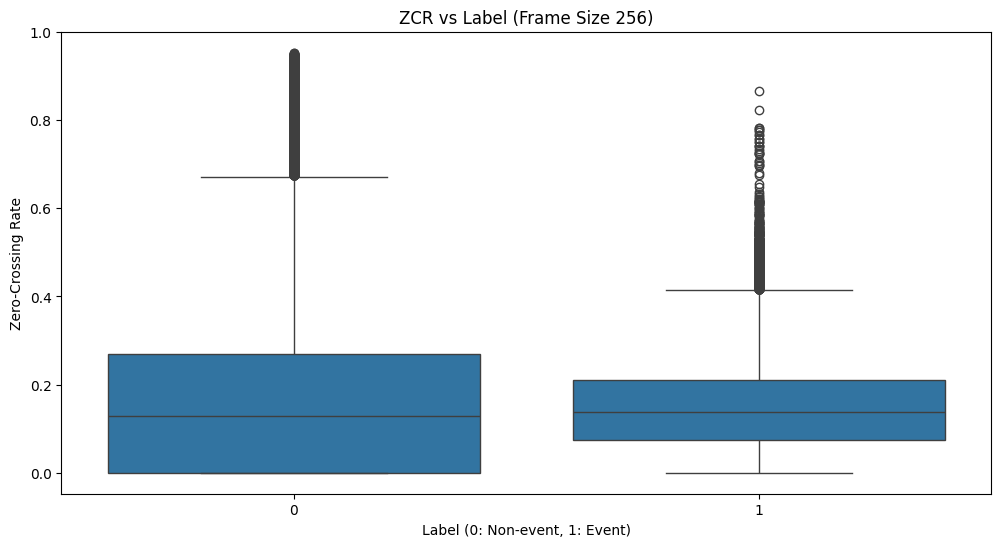

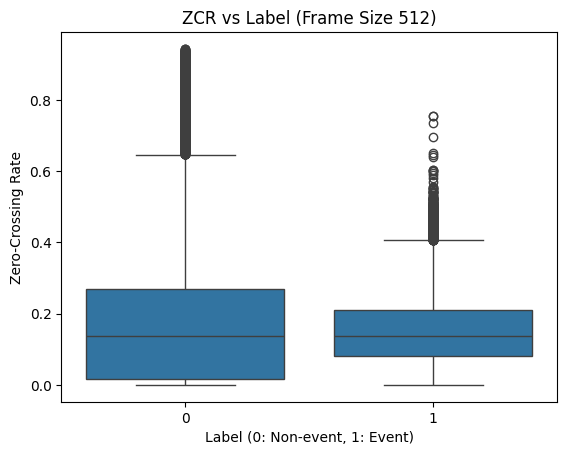

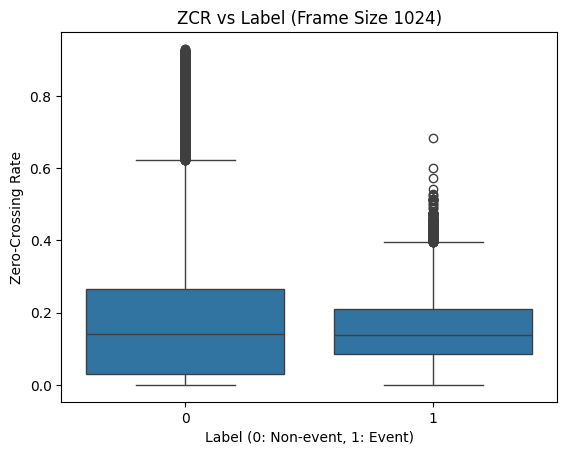

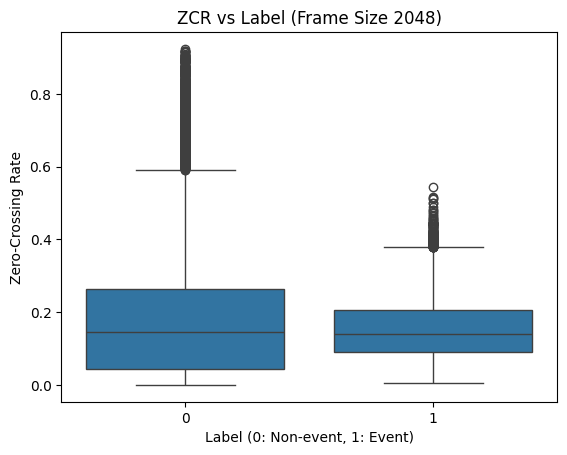

In [ ]:
def calculate_zcr(frame_df):
    def zcr(frame):
        # Convert frame to numpy array if it's not already
        if isinstance(frame, list):
            frame = np.array(frame)

        # Calculate zero-crossing rate
        zero_crossings = librosa.zero_crossings(frame, pad=False)
        return np.sum(zero_crossings) / len(frame)

    # Apply ZCR function to each frame
    frame_df['zcr'] = frame_df['amp'].apply(zcr)
    return frame_df

# Apply ZCR calculation to each frame size
for frame_size in [256, 512, 1024, 2048]:
    all_frames_from_save[frame_size] = calculate_zcr(all_frames_from_save[frame_size])
    print(f"Calculated ZCR for frame size {frame_size}")

# Let's look at the results for one of the frame sizes, e.g., 1024
df_frame_from_save = all_frames_from_save[512]
print("\nFirst few rows of the DataFrame with ZCR (frame size 1024):")
print(df_frame_from_save[['key', 'frame_index', 'zcr', 'label']].head())

# Let's also visualize the distribution of ZCR values
plt.figure(figsize=(12, 6))
for frame_size in [256, 512, 1024, 2048]:
    sns.kdeplot(data=all_frames_from_save[frame_size], x='zcr', label=f'Frame Size {frame_size}')

plt.title('Distribution of Zero-Crossing Rate Across Different Frame Sizes')
plt.xlabel('Zero-Crossing Rate')
plt.ylabel('Density')
plt.show()

# We can also compare ZCR between labeled and non-labeled frames
plt.figure(figsize=(12, 6))
for frame_size in [256, 512, 1024, 2048]:
    df = all_frames_from_save[frame_size]
    sns.boxplot(x='label', y='zcr', data=df)
    plt.title(f'ZCR vs Label (Frame Size {frame_size})')
    plt.xlabel('Label (0: Non-event, 1: Event)')
    plt.ylabel('Zero-Crossing Rate')
    plt.show()